In [475]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from IPython.display import IFrame



pd.set_option('display.max_columns', 500) 

In [477]:
path = r'C:\Users\tanay\Desktop\Tanay Singh Portfolio\Bike Analytics\baywheels_tripdata.csv'
#bike = pd.read_csv(path)
bike = pd.read_csv(path, 
                         dtype = {'ride_id': str, 'rideable_type': str, 'started_at': object, 'ended_at':object, 
                                  'start_station_name': str, 'start_station_id': str, 'end_station_name': str,
                                  'end_station_id' : str, 'start_lat': float, 'start_lng': float, 'end_lat': float,
                                  'end_lng' : float, 'member_casual': str
                                 })

In [103]:
station_mapping = pd.read_csv(r'C:\Users\tanay\Desktop\Tanay Singh Portfolio\Bike Analytics\Bay_Area_Bike_Share_Stations_mapping.csv')
station_mapping.head()

,objectid,Station ID,Station Name,Station ID DOMO,Has Kiosk,Dock Count,Station Latitude,Station Longitude,Region_ID,shape,supervisor_district,analysis_neighborhood,data_loaded_at,data_as_of
0,4,31,Raymond Kimbell Playground,SF-G19,True,31,37.783813,-122.434559,3.0,POINT (-122.434558868 37.783812709),5.0,Western Addition,01/18/2024 03:30:44 PM,01/18/2024 03:28:35 PM
1,27,29,O'Farrell St at Divisadero St,SF-H18,True,27,37.782405,-122.439446,3.0,POINT (-122.439445853 37.782404602),5.0,Western Addition,01/18/2024 03:30:44 PM,01/18/2024 03:28:35 PM
2,36,39,Scott St at Golden Gate Ave,SF-I19,True,27,37.778999,-122.436861,3.0,POINT (-122.4368608 37.7789994),5.0,Western Addition,01/18/2024 03:30:44 PM,01/18/2024 03:28:35 PM
3,41,54,Alamo Square (Steiner St at Fulton St),SF-J19,True,23,37.777547,-122.433274,3.0,POINT (-122.43327409 37.77754677),5.0,Western Addition,01/18/2024 03:30:44 PM,01/18/2024 03:28:35 PM
4,217,285,Webster St at O'Farrell St,SF-H20,True,27,37.783521,-122.431158,3.0,POINT (-122.431157827 37.783520835),5.0,Western Addition,01/18/2024 03:30:44 PM,01/18/2024 03:28:35 PM


In [109]:
bike.isnull().sum()

ride_id               26507
rideable_type         26507
started_at                0
ended_at                  0
start_station_name    11471
start_station_id      11498
end_station_name      12647
end_station_id        12691
start_lat                 0
start_lng                 0
end_lat                  50
end_lng                  50
member_casual             0
dtype: int64

In [121]:
station_mapping = pd.read_csv(r'C:\Users\tanay\Desktop\Tanay Singh Portfolio\Bike Analytics\Bay_Area_Bike_Share_Stations_mapping.csv')

# Extract necessary columns from the station mapping dataset
station_mapping = station_mapping[['Station ID', 'Station Name', 'Station Latitude', 'Station Longitude']]

### --------------------------------------------------------------------------------
### **METHOD 1: Haversine Distance (For Reference Only, NOT Executed)**
### --------------------------------------------------------------------------------
"""
# Define Haversine formula to calculate distances between two latitude/longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi, delta_lambda = np.radians(lat2 - lat1), np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # Distance in km

# Function to find the nearest station using Haversine formula
def find_nearest_station_haversine(lat, lon, stations_df):
    if pd.isna(lat) or pd.isna(lon):
        return None  # Skip if coordinates are missing
    distances = stations_df.apply(lambda row: haversine(lat, lon, row['Station Latitude'], row['Station Longitude']), axis=1)
    nearest_idx = distances.idxmin()
    return stations_df.loc[nearest_idx, 'Station ID']

# Apply function to fill missing start and end station IDs using Haversine
bike['start_station_id'] = bike.apply(
    lambda row: find_nearest_station_haversine(row['start_lat'], row['start_lng'], station_mapping) if pd.isna(row['start_station_id']) else row['start_station_id'],
    axis=1
)

bike['end_station_id'] = bike.apply(
    lambda row: find_nearest_station_haversine(row['end_lat'], row['end_lng'], station_mapping) if pd.isna(row['end_station_id']) else row['end_station_id'],
    axis=1
)
"""
### --------------------------------------------------------------------------------
### **METHOD 2: KDTree (Executed & Optimized)**
### --------------------------------------------------------------------------------

# Prepare station coordinates for KDTree
station_coords = list(zip(station_mapping['Station Latitude'], station_mapping['Station Longitude']))
station_tree = KDTree(station_coords)  # Build a KDTree for fast nearest neighbor search

# Function to find the nearest station using KDTree
def find_nearest_station_kdtree(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return None  # Skip if coordinates are missing
    _, idx = station_tree.query((lat, lon))  # Find nearest station index
    return station_mapping.iloc[idx]['Station ID']

# Apply function to fill missing start and end station IDs using KDTree
bike['start_station_id'] = bike.apply(
    lambda row: find_nearest_station_kdtree(row['start_lat'], row['start_lng']) if pd.isna(row['start_station_id']) else row['start_station_id'],
    axis=1
)

bike['end_station_id'] = bike.apply(
    lambda row: find_nearest_station_kdtree(row['end_lat'], row['end_lng']) if pd.isna(row['end_station_id']) else row['end_station_id'],
    axis=1
)

# Merge back to fill missing station names using Station ID mapping
bike = bike.merge(station_mapping, left_on='start_station_id', right_on='Station ID', how='left', suffixes=('', '_mapped'))
bike['start_station_name'] = bike['start_station_name'].fillna(bike['Station Name'])

bike = bike.merge(station_mapping, left_on='end_station_id', right_on='Station ID', how='left', suffixes=('', '_end'))
bike['end_station_name'] = bike['end_station_name'].fillna(bike['Station Name_end'])

# Drop unnecessary columns after merge
bike.drop(columns=['Station ID', 'Station Name', 'Station Name_end', 'Station Latitude', 
                             'Station Longitude', 'Station Latitude_end', 'Station Longitude_end',
                           'Station ID_end'], inplace=True)

# Recalculate the null values in bike
null_counts_corrected = bike[[
    "ride_id", "rideable_type", "started_at", "ended_at",
    "start_station_name", "start_station_id", "end_station_name", "end_station_id",
    "start_lat", "start_lng", "end_lat", "end_lng", "member_casual"
]].isnull().sum()

# Display the null counts
print(null_counts_corrected)


ride_id               26507
rideable_type         26507
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name         50
end_station_id           50
start_lat                 0
start_lng                 0
end_lat                  50
end_lng                  50
member_casual             0
dtype: int64


In [184]:
object_columns_list = list(bike.select_dtypes(include='object').columns)
object_columns_list
#for object_column in object_columns_list:
#    bike[object_column] = bike[object_column].astype(int)

['ride_id',
 'rideable_type',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'member_casual']

In [200]:
# Convert Excel serial date to datetime format
bike['started_at'] = pd.to_datetime(bike['started_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
bike['ended_at'] = pd.to_datetime(bike['ended_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
bike['started_at'] = pd.to_datetime(bike['started_at'])
bike['ended_at'] = pd.to_datetime(bike['ended_at'])
# Convert specified columns to string type
columns_to_convert = [
    'ride_id',
    'rideable_type',
    'start_station_name',
    'start_station_id',
    'end_station_name',
    'end_station_id',
    'member_casual'
]

bike[columns_to_convert] = bike[columns_to_convert].astype('string')

# Verify conversion
bike.dtypes

ride_id                       string
rideable_type                 string
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            string
start_station_id              string
end_station_name              string
end_station_id                string
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 string
dtype: object

In [202]:
station_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   objectid               472 non-null    int64  
 1   Station ID             472 non-null    int64  
 2   Station Name           472 non-null    object 
 3   Station ID DOMO        472 non-null    object 
 4   Has Kiosk              472 non-null    bool   
 5   Dock Count             472 non-null    int64  
 6   Station Latitude       472 non-null    float64
 7   Station Longitude      472 non-null    float64
 8   Region_ID              463 non-null    float64
 9   shape                  472 non-null    object 
 10  supervisor_district    261 non-null    float64
 11  analysis_neighborhood  261 non-null    object 
 12  data_loaded_at         472 non-null    object 
 13  data_as_of             472 non-null    object 
dtypes: bool(1), float64(4), int64(3), object(6)
memory usage: 

In [203]:
station_mapping['Station ID'] = station_mapping['Station ID'].astype('string')
station_mapping['Station Name'] = station_mapping['Station Name'].astype('string')
station_mapping['Station ID DOMO'] = station_mapping['Station ID DOMO'].astype('string')
station_mapping['Region_ID'] = station_mapping['Region_ID'].astype('string')
station_mapping['analysis_neighborhood'] = station_mapping['analysis_neighborhood'].astype('string')

# Convert 'supervisor_district' to integer (handling possible NaNs)
station_mapping['supervisor_district'] = pd.to_numeric(station_mapping['supervisor_district'], errors='coerce').astype('Int64')


In [206]:
bike.isnull().sum()

ride_id               26507
rideable_type         26507
started_at                0
ended_at                  0
start_station_name    11471
start_station_id      11498
end_station_name      12647
end_station_id        12691
start_lat                 0
start_lng                 0
end_lat                  50
end_lng                  50
member_casual             0
dtype: int64

In [212]:

### --------------------------------------------------------------------------------
### **METHOD 2: KDTree (Executed & Optimized)**
### --------------------------------------------------------------------------------


# Extract relevant columns for matching from station_mapping dataset
station_coords = station_mapping[['Station Latitude', 'Station Longitude']].values
station_ids = station_mapping['Station ID'].values
station_names = station_mapping['Station Name'].values

# Build KDTree for fast nearest neighbor search
station_tree = cKDTree(station_coords)

# Function to find the nearest station
def find_nearest_station(lat, lng):
    if np.isnan(lat) or np.isnan(lng):
        return np.nan, np.nan  # Return None if lat/lng are missing
    _, idx = station_tree.query([lat, lng])  # Find nearest neighbor
    return station_ids[idx], station_names[idx]

# Fill missing start station information
for idx, row in bike[bike['start_station_id'].isna()].iterrows():
    nearest_id, nearest_name = find_nearest_station(row['start_lat'], row['start_lng'])
    bike.at[idx, 'start_station_id'] = nearest_id
    bike.at[idx, 'start_station_name'] = nearest_name

# Fill missing end station information
for idx, row in bike[bike['end_station_id'].isna()].iterrows():
    nearest_id, nearest_name = find_nearest_station(row['end_lat'], row['end_lng'])
    bike.at[idx, 'end_station_id'] = nearest_id
    bike.at[idx, 'end_station_name'] = nearest_name

# Check remaining null values in bike dataset
null_values_bike_updated = bike.isnull().sum()
null_values_bike_updated


ride_id               26507
rideable_type         26507
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name         50
end_station_id           50
start_lat                 0
start_lng                 0
end_lat                  50
end_lng                  50
member_casual             0
dtype: int64

In [213]:
bike.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
15399130,3460CB990C61A046,electric_bike,2024-07-13 01:21:21,2024-07-13 01:25:20,18th St at Noe St,SF-O19,19th St at Mission St,SF-O23,37.761047,-122.432642,37.760278,-122.419074,member
10255004,33B7A45B4ABE86A1,electric_bike,2022-09-10 11:37:36,2022-09-10 11:42:28,21st Ave at Geary Blvd,SF-G8,28th Ave at Geary Blvd,SF-G6,37.779849,-122.480452,37.779673,-122.487970,member
3494563,<NA>,<NA>,2019-08-13 18:05:02,2019-08-13 18:21:22,4th St at Mission Bay Blvd S,93,Yerba Buena Center for the Arts (Howard St at ...,284,37.770407,-122.391198,37.784872,-122.400876,Subscriber
2222211,<NA>,<NA>,2019-02-04 18:58:42,2019-02-04 19:03:18,2nd Ave at E 18th St,200.0,10th St at Fallon St,201.0,37.800214,-122.253810,37.797673,-122.262997,Subscriber
2327866,<NA>,<NA>,2019-03-21 09:06:27,2019-03-21 09:09:32,45th St at Manila,210.0,Miles Ave at Cavour St,205.0,37.833294,-122.256224,37.838800,-122.258732,Subscriber


In [210]:
### --------------------------------------------------------------------------------
### **METHOD: Haversine Distance (For Reference Only, NOT Executed)**
### --------------------------------------------------------------------------------
"""

from math import radians, sin, cos, sqrt, atan2

# Haversine formula to calculate distance between two lat/lng points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])  # Convert to radians

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c  # Distance in km

# Function to find the nearest station using Haversine distance
def find_nearest_station_haversine(lat, lng, station_mapping):
    if pd.isna(lat) or pd.isna(lng):
        return None, None  # Return None if lat/lng are missing
    
    min_distance = float('inf')
    nearest_station_id = None
    nearest_station_name = None

    for _, station in station_mapping.iterrows():
        distance = haversine(lat, lng, station['Station Latitude'], station['Station Longitude'])
        if distance < min_distance:
            min_distance = distance
            nearest_station_id = station['Station ID']
            nearest_station_name = station['Station Name']
    
    return nearest_station_id, nearest_station_name
"""

"\n\nfrom math import radians, sin, cos, sqrt, atan2\n\n# Haversine formula to calculate distance between two lat/lng points\ndef haversine(lat1, lon1, lat2, lon2):\n    R = 6371  # Earth radius in kilometers\n    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])  # Convert to radians\n\n    dlat = lat2 - lat1\n    dlon = lon2 - lon1\n    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2\n    c = 2 * atan2(sqrt(a), sqrt(1-a))\n    return R * c  # Distance in km\n\n# Function to find the nearest station using Haversine distance\ndef find_nearest_station_haversine(lat, lng, station_mapping):\n    if pd.isna(lat) or pd.isna(lng):\n        return None, None  # Return None if lat/lng are missing\n    \n    min_distance = float('inf')\n    nearest_station_id = None\n    nearest_station_name = None\n\n    for _, station in station_mapping.iterrows():\n        distance = haversine(lat, lng, station['Station Latitude'], station['Station Longitude'])\n        if distance 

In [225]:
# Extract datetime components from 'started_at' and 'ended_at'
bike['start_time'] = bike['started_at'].dt.time
bike['start_year'] = bike['started_at'].dt.year
bike['start_month'] = bike['started_at'].dt.month
bike['start_week_number'] = bike['started_at'].dt.isocalendar().week
bike['start_weekday'] = bike['started_at'].dt.weekday
bike['start_weekday_name'] = bike['started_at'].dt.day_name()
bike['start_day'] = bike['started_at'].dt.day
bike['start_hour'] = bike['started_at'].dt.hour
bike['start_minute'] = bike['started_at'].dt.minute
bike['start_second'] = bike['started_at'].dt.second

bike['end_time'] = bike['ended_at'].dt.time
bike['end_year'] = bike['ended_at'].dt.year
bike['end_month'] = bike['ended_at'].dt.month
bike['end_week_number'] = bike['ended_at'].dt.isocalendar().week
bike['end_weekday'] = bike['ended_at'].dt.weekday
bike['end_weekday_name'] = bike['ended_at'].dt.day_name()
bike['end_day'] = bike['ended_at'].dt.day
bike['end_hour'] = bike['ended_at'].dt.hour
bike['end_minute'] = bike['ended_at'].dt.minute
bike['end_second'] = bike['ended_at'].dt.second

# Verify extraction
bike.head()

,started_at,start_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second
15399130,2024-07-13 01:21:21,01:21:21,2024,7,28,5,Saturday,13,1,21,21
10255004,2022-09-10 11:37:36,11:37:36,2022,9,36,5,Saturday,10,11,37,36
3494563,2019-08-13 18:05:02,18:05:02,2019,8,33,1,Tuesday,13,18,5,2
2222211,2019-02-04 18:58:42,18:58:42,2019,2,6,0,Monday,4,18,58,42
2327866,2019-03-21 09:06:27,09:06:27,2019,3,12,3,Thursday,21,9,6,27


In [229]:
bike['start_weekday_name'].unique()

array(['Saturday', 'Tuesday', 'Monday', 'Thursday', 'Friday', 'Wednesday',
       'Sunday'], dtype=object)

In [234]:
bike["start_weekday_name"].value_counts(sort = True)

Thursday     13561
Wednesday    13541
Tuesday      13495
Friday       13192
Monday       12165
Saturday     11495
Sunday       10140
Name: start_weekday_name, dtype: int64

In [231]:
bike["end_weekday_name"].value_counts()

Thursday     13564
Wednesday    13526
Tuesday      13506
Friday       13161
Monday       12169
Saturday     11499
Sunday       10164
Name: end_weekday_name, dtype: int64

In [277]:
weather = pd.read_csv(r"C:\Users\tanay\Desktop\Tanay Singh Portfolio\Bike Analytics\Weather Data\weather_final_2018_25.csv")

In [278]:
weather.head()

,Sno,Time,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,Date
0,1,12:53AM,Cloudy,48°F,47°F,96%,30.20,ENE 6 MPH,0 in.,10mi.,01-01-2018
1,2,1:53AM,Cloudy,47°F,46°F,97%,30.20,SE 3 MPH,0 in.,10mi.,01-01-2018
2,3,2:53AM,Mostly Cloudy,47°F,47°F,100%,30.21,S 3 MPH,0 in.,10mi.,01-01-2018
3,4,3:53AM,Mist and Fog,45°F,45°F,100%,30.22,N 0 MPH,0 in.,3mi.,01-01-2018
4,5,4:53AM,Mist and Fog,42°F,42°F,100%,30.21,N 0 MPH,0 in.,5mi.,01-01-2018


In [279]:
# Convert 'Date' column to proper datetime format (YYYY-MM-DD)
weather['Date'] = pd.to_datetime(weather['Date'], format='%d-%m-%Y', errors='coerce')

# Convert 'Time' column to 24-hour format
weather['Time'] = pd.to_datetime(weather['Time'], format='%I:%M%p', errors='coerce').dt.strftime('%H:%M:%S')

# Combine 'Date' and 'Time' into 'weather_datetime'
weather['weather_datetime'] = pd.to_datetime(weather['Date'].astype(str) + ' ' + weather['Time'].astype(str), errors='coerce')

In [292]:
bike = bike.sort_values("started_at")
weather = weather.sort_values("weather_datetime")

merged_data = pd.merge_asof(
    left=jan2018,
    right=weather,
    left_on="started_at",
    right_on="weather_datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1H") 
)

# 4) Inspect the result
print(f"Merged Row Count: {len(merged_data)}")
merged_data

Merged Row Count: 87589


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,end_year,end_month,end_week_number,end_weekday,end_weekday_name,end_day,end_hour,end_minute,end_second,Sno,Time,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,Date,weather_datetime
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,2018,1,1,0,Monday,1,7,57,5,8.0,07:53:00,Mist and Fog,40°F,40°F,100%,30.24,NNE 6 MPH,0 in.,5mi.,2018-01-01,2018-01-01 07:53:00
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,2018,1,1,0,Monday,1,11,21,38,11.0,10:53:00,Mist and Fog,51°F,48°F,89%,30.26,SSW 3 MPH,0 in.,4mi.,2018-01-01,2018-01-01 10:53:00
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,2018,1,1,0,Monday,1,12,34,57,12.0,11:53:00,Mist and Fog,52°F,48°F,86%,30.23,WSW 5 MPH,0 in.,4mi.,2018-01-01,2018-01-01 11:53:00
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,2018,1,1,0,Monday,1,19,1,14,19.0,18:53:00,Mostly Cloudy,51°F,49°F,92%,30.16,N 0 MPH,0 in.,10mi.,2018-01-01,2018-01-01 18:53:00
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,2018,1,1,1,Tuesday,2,3,59,15,28.0,03:53:00,Cloudy,45°F,42°F,90%,30.17,NE 6 MPH,0 in.,10mi.,2018-01-02,2018-01-02 03:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87584,CA819B38F228489B,electric_bike,2025-02-28 20:18:15,2025-02-28 20:19:42,Union Square,SF-F26,Cyril Magnin St at Ellis St,SF-G26,37.788300,-122.408531,37.785876,-122.408923,member,20:18:15,20:19:42,2025,2,9,4,Friday,28,20,18,15,2025,2,9,4,Friday,28,20,19,42,69111.0,19:53:00,Mostly Cloudy,56°F,53°F,90%,29.93,WNW 5 MPH,0 in.,10mi.,2025-02-28,2025-02-28 19:53:00
87585,DFFA2D60A6AE4368,electric_bike,2025-02-28 20:58:23,2025-02-28 21:03:08,2nd Ave at E 18th St,OK-K9,Frank H Ogawa Plaza,OK-L5,37.800214,-122.253810,37.804562,-122.271738,member,20:58:23,21:03:08,2025,2,9,4,Friday,28,20,58,23,2025,2,9,4,Friday,28,21,3,8,69112.0,20:53:00,Partly Cloudy,55°F,53°F,93%,29.95,N 0 MPH,0 in.,10mi.,2025-02-28,2025-02-28 20:53:00
87586,E2642FB89B746A83,electric_bike,2025-02-28 21:41:43,2025-02-28 22:00:32,2nd St at Folsom St,SF-H29,Francisco St at Columbus Ave,SF-A24-2,37.785199,-122.396217,37.804454,-122.415794,member,21:41:43,22:00:32,2025,2,9,4,Friday,28,21,41,43,2025,2,9,4,Friday,28,22,0,32,69113.0,21:53:00,Partly Cloudy,52°F,50°F,93%,29.95,NW 8 MPH,0 in.,10mi.,2025-02-28,2025-02-28 21:53:00
87587,27A1991B7F7F8A89,classic_bike,2025-02-28 21:59:34,2025-02-28 22:09:32,Terry Francois Blvd at Warriors Way,SF-M30-2,Delancey St at Brannan St,SF-H30-2,37.769095,-122.386333,37.783844,-122.390002,casual,21:59:34,22:09:32,2025,2,9,4,Friday,28,21,59,34,2025,2,9,4,Friday,28,22,9,32,69113.0,21:53:00,Partly Cloudy,52°F,50°F,93%,29.95,NW 8 MPH,0 in.,10mi.,2025-02-28,2025-02-28 21:53:00


In [293]:
merged_data.isnull().sum()

ride_id               26507
rideable_type         26507
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name         50
end_station_id           50
start_lat                 0
start_lng                 0
end_lat                  50
end_lng                  50
member_casual             0
start_time                0
end_time                  0
start_year                0
start_month               0
start_week_number         0
start_weekday             0
start_weekday_name        0
start_day                 0
start_hour                0
start_minute              0
start_second              0
end_year                  0
end_month                 0
end_week_number           0
end_weekday               0
end_weekday_name          0
end_day                   0
end_hour                  0
end_minute                0
end_second                0
Sno                     147
Time                    147
Weather             

In [385]:
# Identify unmatched rows (rides without a weather match)
unmatched_rows = merged_data[merged_data['weather_datetime'].isna()].copy()

# Select relevant weather columns for interpolation
weather_columns = ['Temp', 'Dewpt', 'Hum', 'Pressure', 'Winds', 'Precip', 'Visibility']

# Perform linear interpolation for missing weather values
for col in weather_columns:
    merged_data[col] = merged_data[col].interpolate(method='linear', limit_direction='both')

# Verify that missing values have been interpolated
interpolated_unmatched_rows = merged_data[merged_data['weather_datetime'].isna()]

# Display the count of still unmatched rows after interpolation
remaining_unmatched_count = len(interpolated_unmatched_rows)
remaining_unmatched_count


0

In [386]:
# Drop unmatched rows (where 'weather_datetime' is still NaN)
merged_data.dropna(subset=['weather_datetime'], inplace = True)

# Verify the final row count after dropping unmatched rows
final_row_count = len(merged_data)

# Display the final row count
final_row_count


87442

In [387]:
merged_df = merged_data.copy()

In [388]:
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,end_year,end_month,end_week_number,end_weekday,end_weekday_name,end_day,end_hour,end_minute,end_second,Sno,Time,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,Date,weather_datetime
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,2018,1,1,0,Monday,1,7,57,5,8.0,07:53:00,Mist and Fog,40°F,40°F,100%,30.24,NNE 6 MPH,0 in.,5mi.,2018-01-01,2018-01-01 07:53:00
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,2018,1,1,0,Monday,1,11,21,38,11.0,10:53:00,Mist and Fog,51°F,48°F,89%,30.26,SSW 3 MPH,0 in.,4mi.,2018-01-01,2018-01-01 10:53:00
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,2018,1,1,0,Monday,1,12,34,57,12.0,11:53:00,Mist and Fog,52°F,48°F,86%,30.23,WSW 5 MPH,0 in.,4mi.,2018-01-01,2018-01-01 11:53:00
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,2018,1,1,0,Monday,1,19,1,14,19.0,18:53:00,Mostly Cloudy,51°F,49°F,92%,30.16,N 0 MPH,0 in.,10mi.,2018-01-01,2018-01-01 18:53:00
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,2018,1,1,1,Tuesday,2,3,59,15,28.0,03:53:00,Cloudy,45°F,42°F,90%,30.17,NE 6 MPH,0 in.,10mi.,2018-01-02,2018-01-02 03:53:00


In [389]:
merged_df.drop(['Sno','Time', 'Date', 'weather_datetime'], axis = 1, inplace = True)
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,end_year,end_month,end_week_number,end_weekday,end_weekday_name,end_day,end_hour,end_minute,end_second,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,2018,1,1,0,Monday,1,7,57,5,Mist and Fog,40°F,40°F,100%,30.24,NNE 6 MPH,0 in.,5mi.
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,2018,1,1,0,Monday,1,11,21,38,Mist and Fog,51°F,48°F,89%,30.26,SSW 3 MPH,0 in.,4mi.
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,2018,1,1,0,Monday,1,12,34,57,Mist and Fog,52°F,48°F,86%,30.23,WSW 5 MPH,0 in.,4mi.
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,2018,1,1,0,Monday,1,19,1,14,Mostly Cloudy,51°F,49°F,92%,30.16,N 0 MPH,0 in.,10mi.
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,2018,1,1,1,Tuesday,2,3,59,15,Cloudy,45°F,42°F,90%,30.17,NE 6 MPH,0 in.,10mi.


In [390]:
# Define the haversine function to compute distance in kilometers
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Compute differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371  # Radius of Earth in kilometers
    return round(R * c,2)

# Compute the trip distance for each row in cleaned_df
merged_df['trip_distance_km'] = haversine_distance(
    merged_df['start_lat'],
    merged_df['start_lng'],
    merged_df['end_lat'],
    merged_df['end_lng']
)

# Show a sample of the dataframe with the new distance column
print("Sample of cleaned_df with trip distances:")
print(merged_df[['start_station_name', 'end_station_name', 'trip_distance_km']].head())

# Print descriptive statistics for the trip distances
print("\nDescriptive statistics for trip distances (km):")
print(merged_df['trip_distance_km'].describe())


Sample of cleaned_df with trip distances:
                                  start_station_name  \
0                             Davis St at Jackson St   
1                              Townsend St at 7th St   
2  San Francisco Ferry Building (Harry Bridges Pl...   
3                            30th St at San Jose Ave   
4                        San Pablo Ave at MLK Jr Way   

                end_station_name  trip_distance_km  
0         Davis St at Jackson St              0.00  
1     Rhode Island St at 17th St              0.73  
2  The Embarcadero at Sansome St              1.31  
3          19th St at Mission St              2.04  
4       Telegraph Ave at 19th St              0.43  

Descriptive statistics for trip distances (km):
count    87392.000000
mean         1.884993
std          1.370905
min          0.000000
25%          0.930000
50%          1.570000
75%          2.550000
max         33.930000
Name: trip_distance_km, dtype: float64


In [307]:
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,end_year,end_month,end_week_number,end_weekday,end_weekday_name,end_day,end_hour,end_minute,end_second,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,trip_distance_km,trip_duration_minutes,trip_duration_seconds,trip_duration_hours
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,2018,1,1,0,Monday,1,7,57,5,Mist and Fog,40°F,40°F,100%,30.24,NNE 6 MPH,0 in.,5mi.,0.00,23.0,1399.0,0.0
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,2018,1,1,0,Monday,1,11,21,38,Mist and Fog,51°F,48°F,89%,30.26,SSW 3 MPH,0 in.,4mi.,0.73,5.0,313.0,0.0
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,2018,1,1,0,Monday,1,12,34,57,Mist and Fog,52°F,48°F,86%,30.23,WSW 5 MPH,0 in.,4mi.,1.31,20.0,1170.0,0.0
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,2018,1,1,0,Monday,1,19,1,14,Mostly Cloudy,51°F,49°F,92%,30.16,N 0 MPH,0 in.,10mi.,2.04,8.0,496.0,0.0
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,2018,1,1,1,Tuesday,2,3,59,15,Cloudy,45°F,42°F,90%,30.17,NE 6 MPH,0 in.,10mi.,0.43,5.0,318.0,0.0


In [391]:
merged_df['trip_duration_seconds'] = (merged_df['ended_at'] - merged_df['started_at']).dt.total_seconds() 

In [392]:
# Create new columns for trip duration in minutes and hours
merged_df['trip_duration_minutes'] = round(merged_df['trip_duration_seconds'] / 60.0,0)
merged_df['trip_duration_hours'] = round(merged_df['trip_duration_seconds'] / 3600.0,0)

# Display a sample of the duration columns
print("Sample of duration columns:")
print(merged_df[['trip_duration_seconds', 'trip_duration_minutes', 'trip_duration_hours']].head())


Sample of duration columns:
   trip_duration_seconds  trip_duration_minutes  trip_duration_hours
0                 1399.0                   23.0                  0.0
1                  313.0                    5.0                  0.0
2                 1170.0                   20.0                  0.0
3                  496.0                    8.0                  0.0
4                  318.0                    5.0                  0.0


In [393]:
# Group trip data by route (start and end station) and count trips
route_counts = merged_df.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='trip_count')

# Sort by trip count in descending order and get the top 20 routes
top_20_routes = route_counts.sort_values(by='trip_count', ascending=False).head(20)

# Merge the top 20 routes with station mapping data to get dock count and neighborhood info
top_20_routes_with_info = top_20_routes.merge(
    station_mapping[['Station Name', 'Dock Count', 'analysis_neighborhood']],
    left_on='start_station_name',
    right_on='Station Name',
    how='left'
).rename(columns={'Dock Count': 'start_dock_count', 'analysis_neighborhood': 'start_neighborhood'}).drop(columns=['Station Name'])

top_20_routes_with_info = top_20_routes_with_info.merge(
    station_mapping[['Station Name', 'Dock Count', 'analysis_neighborhood']],
    left_on='end_station_name',
    right_on='Station Name',
    how='left'
).rename(columns={'Dock Count': 'end_dock_count', 'analysis_neighborhood': 'end_neighborhood'}).drop(columns=['Station Name'])

# Display the updated top 20 routes with dock count and neighborhood info
top_20_routes_with_info.head(20)


,start_station_name,end_station_name,trip_count,start_dock_count,start_neighborhood,end_dock_count,end_neighborhood
0,Civic Center/UN Plaza BART Station (Market St ...,Civic Center/UN Plaza BART Station (Market St ...,86,31,South of Market,31.0,South of Market
1,San Francisco Ferry Building (Harry Bridges Pl...,The Embarcadero at Sansome St,77,38,Financial District/South Beach,23.0,Financial District/South Beach
2,48th Ave at Cabrillo St,48th Ave at Cabrillo St,76,23,Outer Richmond,23.0,Outer Richmond
3,Metro Dr at Technology Dr,Metro Dr at Technology Dr,74,23,<NA>,23.0,<NA>
4,Montgomery St BART Station (Market St at 2nd St),Montgomery St BART Station (Market St at 2nd St),67,39,Financial District/South Beach,39.0,Financial District/South Beach
5,Union Square (Powell St at Post St),Union Square (Powell St at Post St),63,27,Nob Hill,27.0,Nob Hill
6,19th Street BART Station,Grand Ave at Perkins St,61,31,<NA>,23.0,<NA>
7,Berry St at 4th St,San Francisco Ferry Building (Harry Bridges Pl...,61,35,Mission Bay,38.0,Financial District/South Beach
8,North Point St at Divisadero St,North Point St at Divisadero St,56,0,Marina,0.0,Marina
9,Powell St at Columbus Ave,Powell St at Columbus Ave,54,30,Chinatown,30.0,Chinatown


In [394]:
round(merged_df.isnull().sum()/len(merged_df) *100,1)

ride_id                  30.2
rideable_type            30.2
started_at                0.0
ended_at                  0.0
start_station_name        0.0
start_station_id          0.0
end_station_name          0.1
end_station_id            0.1
start_lat                 0.0
start_lng                 0.0
end_lat                   0.1
end_lng                   0.1
member_casual             0.0
start_time                0.0
end_time                  0.0
start_year                0.0
start_month               0.0
start_week_number         0.0
start_weekday             0.0
start_weekday_name        0.0
start_day                 0.0
start_hour                0.0
start_minute              0.0
start_second              0.0
end_year                  0.0
end_month                 0.0
end_week_number           0.0
end_weekday               0.0
end_weekday_name          0.0
end_day                   0.0
end_hour                  0.0
end_minute                0.0
end_second                0.0
Weather   

Values cannot be imputed since the station ID is missing. Technically speaking, the ID is not missing. It just doesn't 
exist in the list of San Francisco Dataset since the station ID was changed. We shall leave the missing values as is for now.

In [395]:
# Removing false start trips
merged_df = merged_df[(merged_df['trip_duration_seconds']>=60)]

# Removing outliers
q1 = merged_df['trip_duration_seconds'].quantile(0.25)
q3 = merged_df['trip_duration_seconds'].quantile(0.75)

interquartile_range = q3 - q1

merged_df = merged_df[~((merged_df['trip_duration_seconds'] < (q1 - 1.5 * interquartile_range)) \
         |(merged_df['trip_duration_seconds'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)
merged_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,end_year,end_month,end_week_number,end_weekday,end_weekday_name,end_day,end_hour,end_minute,end_second,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,2018,1,1,0,Monday,1,7,57,5,Mist and Fog,40°F,40°F,100%,30.24,NNE 6 MPH,0 in.,5mi.,0.00,1399.0,23.0,0.0
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,2018,1,1,0,Monday,1,11,21,38,Mist and Fog,51°F,48°F,89%,30.26,SSW 3 MPH,0 in.,4mi.,0.73,313.0,5.0,0.0
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,2018,1,1,0,Monday,1,12,34,57,Mist and Fog,52°F,48°F,86%,30.23,WSW 5 MPH,0 in.,4mi.,1.31,1170.0,20.0,0.0
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,2018,1,1,0,Monday,1,19,1,14,Mostly Cloudy,51°F,49°F,92%,30.16,N 0 MPH,0 in.,10mi.,2.04,496.0,8.0,0.0
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,2018,1,1,1,Tuesday,2,3,59,15,Cloudy,45°F,42°F,90%,30.17,NE 6 MPH,0 in.,10mi.,0.43,318.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80202,96C01CAA3C69FAC3,electric_bike,2025-02-28 19:36:45,2025-02-28 19:45:25,Bay St at Fillmore St,SF-B19,Polk St at Bush St,SF-F23-2,37.802664,-122.436064,37.788479,-122.420335,member,19:36:45,19:45:25,2025,2,9,4,Friday,28,19,36,45,2025,2,9,4,Friday,28,19,45,25,Mostly Cloudy,56°F,53°F,90%,29.93,WNW 5 MPH,0 in.,10mi.,2.10,520.0,9.0,0.0
80203,CA819B38F228489B,electric_bike,2025-02-28 20:18:15,2025-02-28 20:19:42,Union Square,SF-F26,Cyril Magnin St at Ellis St,SF-G26,37.788300,-122.408531,37.785876,-122.408923,member,20:18:15,20:19:42,2025,2,9,4,Friday,28,20,18,15,2025,2,9,4,Friday,28,20,19,42,Mostly Cloudy,56°F,53°F,90%,29.93,WNW 5 MPH,0 in.,10mi.,0.27,87.0,1.0,0.0
80204,DFFA2D60A6AE4368,electric_bike,2025-02-28 20:58:23,2025-02-28 21:03:08,2nd Ave at E 18th St,OK-K9,Frank H Ogawa Plaza,OK-L5,37.800214,-122.253810,37.804562,-122.271738,member,20:58:23,21:03:08,2025,2,9,4,Friday,28,20,58,23,2025,2,9,4,Friday,28,21,3,8,Partly Cloudy,55°F,53°F,93%,29.95,N 0 MPH,0 in.,10mi.,1.65,285.0,5.0,0.0
80205,E2642FB89B746A83,electric_bike,2025-02-28 21:41:43,2025-02-28 22:00:32,2nd St at Folsom St,SF-H29,Francisco St at Columbus Ave,SF-A24-2,37.785199,-122.396217,37.804454,-122.415794,member,21:41:43,22:00:32,2025,2,9,4,Friday,28,21,41,43,2025,2,9,4,Friday,28,22,0,32,Partly Cloudy,52°F,50°F,93%,29.95,NW 8 MPH,0 in.,10mi.,2.75,1129.0,19.0,0.0


In [316]:
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,end_year,end_month,end_week_number,end_weekday,end_weekday_name,end_day,end_hour,end_minute,end_second,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,trip_distance_km,trip_duration_minutes,trip_duration_seconds,trip_duration_hours
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,2018,1,1,0,Monday,1,7,57,5,Mist and Fog,40°F,40°F,100%,30.24,NNE 6 MPH,0 in.,5mi.,0.00,23.0,1399.0,0.0
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,2018,1,1,0,Monday,1,11,21,38,Mist and Fog,51°F,48°F,89%,30.26,SSW 3 MPH,0 in.,4mi.,0.73,5.0,313.0,0.0
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,2018,1,1,0,Monday,1,12,34,57,Mist and Fog,52°F,48°F,86%,30.23,WSW 5 MPH,0 in.,4mi.,1.31,20.0,1170.0,0.0
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,2018,1,1,0,Monday,1,19,1,14,Mostly Cloudy,51°F,49°F,92%,30.16,N 0 MPH,0 in.,10mi.,2.04,8.0,496.0,0.0
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,2018,1,1,1,Tuesday,2,3,59,15,Cloudy,45°F,42°F,90%,30.17,NE 6 MPH,0 in.,10mi.,0.43,5.0,318.0,0.0


In [396]:
#Checking what trips start in one both but end in another. 

# Extract start and end month-year for each trip
merged_df['start_month_year'] = merged_df['started_at'].dt.to_period('M')
merged_df['end_month_year'] = merged_df['ended_at'].dt.to_period('M')

# Count trips where the start and end month-year are different
cross_month_trips = merged_df[merged_df['start_month_year'] != merged_df['end_month_year']]

# Get the count of such trips
cross_month_trip_count = cross_month_trips

# Display the count
print(cross_month_trip_count, cross_month_trips)


                ride_id  rideable_type          started_at  \
28862  755EBE5D9A968A6F  electric_bike 2020-10-31 23:51:06   
50596  82000EA75D987FF7  electric_bike 2022-12-31 23:50:54   
75345  DA4366E97FD7D584  electric_bike 2024-10-31 23:51:39   

                 ended_at          start_station_name start_station_id  \
28862 2020-11-01 00:16:48    Funston Ave at Fulton St              485   
50596 2023-01-01 00:05:03        8th St at Brannan St           SF-K26   
75345 2024-11-01 00:13:22  16th St Mission BART North        SF-N22-1B   

               end_station_name end_station_id  start_lat   start_lng  \
28862      Haight St at Lyon St            538  37.770000 -122.470000   
50596  Post St at Divisadero St         SF-G18  37.771604 -122.405858   
75345     25th Ave at Irving St          SF-M7  37.764839 -122.420141   

         end_lat     end_lng member_casual start_time  end_time  start_year  \
28862  37.770000 -122.440000        casual   23:51:06  00:16:48        2020   
505

In [397]:
# Drop unnecessary columns related to the 'ended_at' breakdown
columns_to_drop = [
    'end_year', 'end_month', 'end_week_number', 'end_weekday', 'end_weekday_name',
    'end_day', 'end_hour', 'end_minute', 'end_second', 'start_month_year', 'end_month_year'
]

# Drop the columns
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

# Display the updated dataset
merged_df.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,Mist and Fog,40°F,40°F,100%,30.24,NNE 6 MPH,0 in.,5mi.,0.00,1399.0,23.0,0.0
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,Mist and Fog,51°F,48°F,89%,30.26,SSW 3 MPH,0 in.,4mi.,0.73,313.0,5.0,0.0
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,Mist and Fog,52°F,48°F,86%,30.23,WSW 5 MPH,0 in.,4mi.,1.31,1170.0,20.0,0.0
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,Mostly Cloudy,51°F,49°F,92%,30.16,N 0 MPH,0 in.,10mi.,2.04,496.0,8.0,0.0
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,Cloudy,45°F,42°F,90%,30.17,NE 6 MPH,0 in.,10mi.,0.43,318.0,5.0,0.0


In [398]:
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Use .replace() to create a new column with the mapped month names.
merged_df['month_name'] = merged_df['start_month'].replace(month_mapping)

In [399]:
# Aggregate ridership by started_at date and user type, counting unique trips
ridership_summary = merged_df.groupby([merged_df['started_at'].dt.date, 'member_casual']).agg(
    unique_trips=('ride_id', 'nunique')  # Count unique trips
).reset_index().rename(columns={'started_at': 'Date'})

# Display the updated ridership summary
ridership_summary


,Date,member_casual,unique_trips
0,2018-01-01,Customer,0
1,2018-01-01,Subscriber,0
2,2018-01-02,Subscriber,0
3,2018-01-03,Customer,0
4,2018-01-03,Subscriber,0
...,...,...,...
5123,2025-02-26,member,42
5124,2025-02-27,casual,4
5125,2025-02-27,member,45
5126,2025-02-28,casual,10


In [400]:
# Ensure the 'Winds' column is a string
merged_df['Winds'] = merged_df['Winds'].astype(str)

# Create a new column 'wind_direction' that contains only the wind direction (first token)
merged_df['wind_direction'] = merged_df['Winds'].apply(lambda x: x.split()[0] if x.strip() != "" else "")

# Create a new column 'wind_speed' that contains only the wind speed (second token) and convert it to float

merged_df['wind_speed_kmh'] = merged_df['Winds'].apply(lambda x: float(x.split()[1]) if len(x.split()) > 1 else 0.0)


# Convert the wind speed from MPH to KM/H
merged_df['wind_speed_kmh'] = merged_df['wind_speed_kmh'] * 1.60934

#Round the values
merged_df['wind_speed_kmh'] = merged_df['wind_speed_kmh'].apply(lambda x: round(x) if x != "" else 0.0)

# Display a few rows to verify
print(merged_df[['Winds', 'wind_direction', 'wind_speed_kmh']].head())

merged_df.drop('Winds', axis = 1, inplace = True)

       Winds wind_direction  wind_speed_kmh
0  NNE 6 MPH            NNE              10
1  SSW 3 MPH            SSW               5
2  WSW 5 MPH            WSW               8
3    N 0 MPH              N               0
4   NE 6 MPH             NE              10


In [401]:
merged_df['wind_direction'].value_counts()

W      21955
WNW    17627
N       8116
NW      8086
WSW     5393
SW      2996
SSW     2040
NNW     2038
S       2018
SE      1778
SSE     1636
E       1186
ENE     1131
NE      1117
VRB     1109
NNE     1054
ESE      910
MPH       17
Name: wind_direction, dtype: int64

In [402]:
merged_df['wind_speed_kmh'].value_counts()

10    6918
0     6755
11    6671
8     6269
13    6139
5     5529
14    5302
16    5142
21    5058
19    4936
23    4931
24    4839
26    3666
27    2915
29    1905
32    1094
34     620
35     383
37     287
39     240
40     130
42     123
45      87
47      61
48      58
50      37
51      35
58      19
56      17
53      16
60       6
18       5
61       5
66       3
63       2
77       1
72       1
71       1
69       1
Name: wind_speed_kmh, dtype: int64

In [ ]:
#VRB: Variable Wind Direction. Usually measured in Knots

In [403]:
# Merge station mapping data to bring in 'analysis_neighborhood' and 'Dock Count' for start and end stations
merged_df = merged_df.merge(
    station_mapping[['Station Name', 'Dock Count', 'analysis_neighborhood', 'Has Kiosk']],
    left_on='start_station_name',
    right_on='Station Name',
    how='left'
).rename(columns={'Dock Count': 'start_dock_count', 'analysis_neighborhood': 'start_neighborhood', 'Has Kiosk': 'start_station_kiosk_count'}).drop(columns=['Station Name'])

merged_df = merged_df.merge(
    station_mapping[['Station Name', 'Dock Count', 'analysis_neighborhood', 'Has Kiosk']],
    left_on='end_station_name',
    right_on='Station Name',
    how='left'
).rename(columns={'Dock Count': 'end_dock_count', 'analysis_neighborhood': 'end_neighborhood', 'Has Kiosk': 'end_station_kiosk_count'}).drop(columns=['Station Name'])

# Display the updated dataset with neighborhood and dock count information
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,Weather,Temp,Dewpt,Hum,Pressure,Precip,Visibility,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours,month_name,wind_direction,wind_speed_kmh,start_dock_count,start_neighborhood,start_station_kiosk_count,end_dock_count,end_neighborhood,end_station_kiosk_count
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,Mist and Fog,40°F,40°F,100%,30.24,0 in.,5mi.,0.00,1399.0,23.0,0.0,January,NNE,10,35.0,Financial District/South Beach,True,35.0,Financial District/South Beach,True
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,Mist and Fog,51°F,48°F,89%,30.26,0 in.,4mi.,0.73,313.0,5.0,0.0,January,SSW,5,27.0,South of Market,True,19.0,Potrero Hill,True
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,Mist and Fog,52°F,48°F,86%,30.23,0 in.,4mi.,1.31,1170.0,20.0,0.0,January,WSW,8,38.0,Financial District/South Beach,True,23.0,Financial District/South Beach,True
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,Mostly Cloudy,51°F,49°F,92%,30.16,0 in.,10mi.,2.04,496.0,8.0,0.0,January,N,0,15.0,Bernal Heights,True,19.0,Mission,True
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,Cloudy,45°F,42°F,90%,30.17,0 in.,10mi.,0.43,318.0,5.0,0.0,January,NE,10,19.0,<NA>,True,27.0,<NA>,True


In [404]:
merged_df.isnull().sum()

ride_id                      25150
rideable_type                25150
started_at                       0
ended_at                         0
start_station_name               0
start_station_id                 0
end_station_name                 0
end_station_id                   0
start_lat                        0
start_lng                        0
end_lat                          0
end_lng                          0
member_casual                    0
start_time                       0
end_time                         0
start_year                       0
start_month                      0
start_week_number                0
start_weekday                    0
start_weekday_name               0
start_day                        0
start_hour                       0
start_minute                     0
start_second                     0
Weather                          4
Temp                             0
Dewpt                            0
Hum                              0
Pressure            

In [405]:


# Ensure the 'Temp' column is a string and remove the '°F' part, then strip whitespace
merged_df['temp_f'] = merged_df['Temp'].astype(str).str.replace("°F", "", regex=False).str.strip()

# Replace empty strings or invalid values with NaN before conversion
merged_df['temp_f'] = merged_df['temp_f'].replace('', np.nan)

# Convert the extracted value to float safely
merged_df['temp_f'] = pd.to_numeric(merged_df['temp_f'], errors='coerce')

# Display a few rows to verify the result
merged_df[['Temp', 'temp_f']].head()


,Temp,temp_f
0,40°F,40.0
1,51°F,51.0
2,52°F,52.0
3,51°F,51.0
4,45°F,45.0


In [406]:


# Ensure 'Precip' is a string and extract precipitation value
merged_df['Precip'] = merged_df['Precip'].astype(str)
merged_df['precip_in'] = merged_df['Precip'].apply(lambda x: x.split()[0] if x.strip() != "" else np.nan)
# Replace 'in.' with '0.0' in the 'precip_in' column
merged_df['precip_in'] = merged_df['precip_in'].replace('in.', '0.0')

# Convert the column to numeric format safely
merged_df['precip_in'] = pd.to_numeric(merged_df['precip_in'], errors='coerce')
merged_df['precip_in']  = merged_df['precip_in'].astype(float)


# Ensure 'Visibility' is a string and extract numeric visibility in miles
# Replace empty strings or invalid values with NaN before conversion
merged_df['Visibility'] = merged_df['Visibility'].replace('', np.nan)

# Convert Visibility to float safely after removing 'mi.'
merged_df['visibility_mi'] = merged_df['Visibility'].astype(str).str.replace('mi.', '', regex=False).str.strip()
merged_df['visibility_mi'] = pd.to_numeric(merged_df['visibility_mi'], errors='coerce')

# Convert visibility from miles to kilometers
merged_df['visibility_mi'] = merged_df['visibility_mi'] * 1.60934

# Round visibility values
merged_df['visibility_mi'] = merged_df['visibility_mi'].apply(lambda x: round(x) if not np.isnan(x) else 0.0)


# Ensure 'Dewpt' is a string, remove '°F', and convert to float
merged_df['dewpt_f'] = merged_df['Dewpt'].astype(str).str.replace("°F", "", regex=False).str.strip().replace("", np.nan)
merged_df['dewpt_f'] = merged_df['dewpt_f'].astype(float)

# Ensure 'Hum' is a string, remove '%', and convert to float
merged_df['hum_%'] = merged_df['Hum'].astype(str).str.replace("%", "", regex=False).str.strip().replace("", np.nan)
merged_df['hum_%'] = merged_df['hum_%'].astype(float)

# Display updated columns
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,Weather,Temp,Dewpt,Hum,Pressure,Precip,Visibility,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours,month_name,wind_direction,wind_speed_kmh,start_dock_count,start_neighborhood,start_station_kiosk_count,end_dock_count,end_neighborhood,end_station_kiosk_count,temp_f,precip_in,visibility_mi,dewpt_f,hum_%
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,Mist and Fog,40°F,40°F,100%,30.24,0 in.,5mi.,0.00,1399.0,23.0,0.0,January,NNE,10,35.0,Financial District/South Beach,True,35.0,Financial District/South Beach,True,40.0,0.0,8.0,40.0,100.0
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,Mist and Fog,51°F,48°F,89%,30.26,0 in.,4mi.,0.73,313.0,5.0,0.0,January,SSW,5,27.0,South of Market,True,19.0,Potrero Hill,True,51.0,0.0,6.0,48.0,89.0
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,Mist and Fog,52°F,48°F,86%,30.23,0 in.,4mi.,1.31,1170.0,20.0,0.0,January,WSW,8,38.0,Financial District/South Beach,True,23.0,Financial District/South Beach,True,52.0,0.0,6.0,48.0,86.0
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,Mostly Cloudy,51°F,49°F,92%,30.16,0 in.,10mi.,2.04,496.0,8.0,0.0,January,N,0,15.0,Bernal Heights,True,19.0,Mission,True,51.0,0.0,16.0,49.0,92.0
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,Cloudy,45°F,42°F,90%,30.17,0 in.,10mi.,0.43,318.0,5.0,0.0,January,NE,10,19.0,<NA>,True,27.0,<NA>,True,45.0,0.0,16.0,42.0,90.0


In [408]:
merged_df[merged_df['precip_in'] == 0.110]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,Weather,Temp,Dewpt,Hum,Pressure,Precip,Visibility,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours,month_name,wind_direction,wind_speed_kmh,start_dock_count,start_neighborhood,start_station_kiosk_count,end_dock_count,end_neighborhood,end_station_kiosk_count,temp_f,precip_in,visibility_mi,dewpt_f,hum_%
11766,<NA>,<NA>,2019-03-27 11:18:13,2019-03-27 11:23:22,Valencia St at 21st St,127.0,Harrison St at 17th St,112.0,37.756708,-122.421025,37.763847,-122.413004,Subscriber,11:18:13,11:23:22,2019,3,13,2,Wednesday,27,11,18,13,Heavy Rain,59°F,56°F,90%,29.98,0.11 in.,1.75mi.,1.06,309.0,5.0,0.0,March,SSW,19,23.0,Mission,True,19.0,Mission,True,59.0,0.11,3.0,56.0,90.0
50643,4C5438D9B94592A1,electric_bike,2023-01-04 07:25:13,2023-01-04 07:27:30,20th St at Bryant St,125,22nd St at Potrero Ave,SF-P26,37.760000,-122.410000,37.756808,-122.405943,member,07:25:13,07:27:30,2023,1,1,2,Wednesday,4,7,25,13,Light Rain,51°F,48°F,89%,29.80,0.11 in.,10mi.,0.50,137.0,2.0,0.0,January,E,19,15.0,Mission,True,15.0,Mission,True,51.0,0.11,16.0,48.0,89.0
52000,A314EEE4B2FC6516,electric_bike,2023-02-28 10:34:52,2023-02-28 10:45:04,Fern St at Polk St,419,Salesforce Transit Center (Natoma St at 2nd St),SF-G29-1,37.790000,-122.420000,37.787492,-122.398285,casual,10:34:52,10:45:04,2023,2,9,1,Tuesday,28,10,34,52,Rain,45°F,42°F,90%,29.95,0.11 in.,4mi.,1.93,612.0,10.0,0.0,February,SSE,34,21.0,Nob Hill,True,35.0,Financial District/South Beach,True,45.0,0.11,6.0,42.0,90.0
62317,2671759AA0A076DA,classic_bike,2024-01-02 17:17:38,2024-01-02 17:24:20,29th St at Tiffany Ave,SF-T22,Jersey St at Church St,SF-R20,37.744067,-122.421472,37.750900,-122.427411,member,17:17:38,17:24:20,2024,1,1,1,Tuesday,2,17,17,38,Heavy Rain,53°F,53°F,100%,30.06,0.11 in.,2.5mi.,0.92,402.0,7.0,0.0,January,SW,21,19.0,Bernal Heights,True,19.0,Noe Valley,True,53.0,0.11,4.0,53.0,100.0
62415,8DEFA0DA63565762,electric_bike,2024-01-06 14:36:37,2024-01-06 14:40:25,Folsom St at 19th St,SF-O24,16th St Mission BART,SF-N22-1A,37.760704,-122.414805,37.764685,-122.419927,member,14:36:37,14:40:25,2024,1,1,5,Saturday,6,14,36,37,Rain,52°F,51°F,97%,29.99,0.11 in.,3mi.,0.63,228.0,4.0,0.0,January,WNW,42,19.0,Mission,True,11.0,Mission,True,52.0,0.11,5.0,51.0,97.0
62675,EDA70515D08676A3,electric_bike,2024-01-16 18:19:19,2024-01-16 18:22:27,16th St Mission BART,SF-N22-1A,Folsom St at 19th St,SF-O24,37.764728,-122.419931,37.760594,-122.414817,member,18:19:19,18:22:27,2024,1,3,1,Tuesday,16,18,19,19,Rain,53°F,53°F,100%,30.02,0.11 in.,1.5mi.,0.64,188.0,3.0,0.0,January,N,0,11.0,Mission,True,19.0,Mission,True,53.0,0.11,2.0,53.0,100.0
64047,87186BD088424B75,electric_bike,2024-03-01 20:36:05,2024-03-01 20:46:41,Folsom St at 9th St,SF-K25,Market St at Franklin St,SF-K22-1,37.773467,-122.411826,37.773793,-122.421239,casual,20:36:05,20:46:41,2024,3,9,4,Friday,1,20,36,5,Rain,52°F,50°F,93%,29.78,0.11 in.,3mi.,0.83,636.0,11.0,0.0,March,SW,35,27.0,South of Market,True,35.0,Hayes Valley,True,52.0,0.11,5.0,50.0,93.0
65371,D6592889112B7B4F,classic_bike,2024-04-04 08:45:52,2024-04-04 08:55:16,Market St at Franklin St,SF-K22-1,2nd St at Folsom St,SF-H29,37.773793,-122.421239,37.785199,-122.396217,member,08:45:52,08:55:16,2024,4,14,3,Thursday,4,8,45,52,Rain,46°F,43°F,89%,29.82,0.11 in.,5mi.,2.54,564.0,9.0,0.0,April,W,24,35.0,Hayes Valley,True,37.0,Financial District/South Beach,True,46.0,0.11,8.0,43.0,89.0
77296,5B87E92F8D405534,electric_bike,2024-12-16 13:43:28,2024-12-16 13:50:58,Golden Gate Ave at Polk St,SF-I23-1,Harrison St at 17th St,SF-N24-2,37.781361,-122.418530,37.763847,-122.413004,member,13:43:28,13:50:58,2024,12,51,0,Monday,16,13,43,28,Light Rain,54°F,50°F,88%,30.12,0.11 in.,2mi.,2.01,450.0,8.0,0.0,Decemb

In [409]:
merged_df.drop([ 'Visibility', 'Precip','Dewpt','Hum', 'Temp' ], axis =1, inplace = True)
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,Weather,Pressure,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours,month_name,wind_direction,wind_speed_kmh,start_dock_count,start_neighborhood,start_station_kiosk_count,end_dock_count,end_neighborhood,end_station_kiosk_count,temp_f,precip_in,visibility_mi,dewpt_f,hum_%
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,Mist and Fog,30.24,0.00,1399.0,23.0,0.0,January,NNE,10,35.0,Financial District/South Beach,True,35.0,Financial District/South Beach,True,40.0,0.0,8.0,40.0,100.0
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,Mist and Fog,30.26,0.73,313.0,5.0,0.0,January,SSW,5,27.0,South of Market,True,19.0,Potrero Hill,True,51.0,0.0,6.0,48.0,89.0
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,Mist and Fog,30.23,1.31,1170.0,20.0,0.0,January,WSW,8,38.0,Financial District/South Beach,True,23.0,Financial District/South Beach,True,52.0,0.0,6.0,48.0,86.0
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,Mostly Cloudy,30.16,2.04,496.0,8.0,0.0,January,N,0,15.0,Bernal Heights,True,19.0,Mission,True,51.0,0.0,16.0,49.0,92.0
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,Cloudy,30.17,0.43,318.0,5.0,0.0,January,NE,10,19.0,<NA>,True,27.0,<NA>,True,45.0,0.0,16.0,42.0,90.0


# Visualizations

In [413]:
merged_df_1 = merged_df

In [414]:
merged_df.member_casual.value_counts()

member        35374
Subscriber    20338
casual        19683
Customer       4812
Name: member_casual, dtype: Int64

In [415]:
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,Weather,Pressure,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours,month_name,wind_direction,wind_speed_kmh,start_dock_count,start_neighborhood,start_station_kiosk_count,end_dock_count,end_neighborhood,end_station_kiosk_count,temp_f,precip_in,visibility_mi,dewpt_f,hum_%
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,Mist and Fog,30.24,0.00,1399.0,23.0,0.0,January,NNE,10,35.0,Financial District/South Beach,True,35.0,Financial District/South Beach,True,40.0,0.0,8.0,40.0,100.0
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,Mist and Fog,30.26,0.73,313.0,5.0,0.0,January,SSW,5,27.0,South of Market,True,19.0,Potrero Hill,True,51.0,0.0,6.0,48.0,89.0
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,Mist and Fog,30.23,1.31,1170.0,20.0,0.0,January,WSW,8,38.0,Financial District/South Beach,True,23.0,Financial District/South Beach,True,52.0,0.0,6.0,48.0,86.0
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,Mostly Cloudy,30.16,2.04,496.0,8.0,0.0,January,N,0,15.0,Bernal Heights,True,19.0,Mission,True,51.0,0.0,16.0,49.0,92.0
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,Cloudy,30.17,0.43,318.0,5.0,0.0,January,NE,10,19.0,<NA>,True,27.0,<NA>,True,45.0,0.0,16.0,42.0,90.0


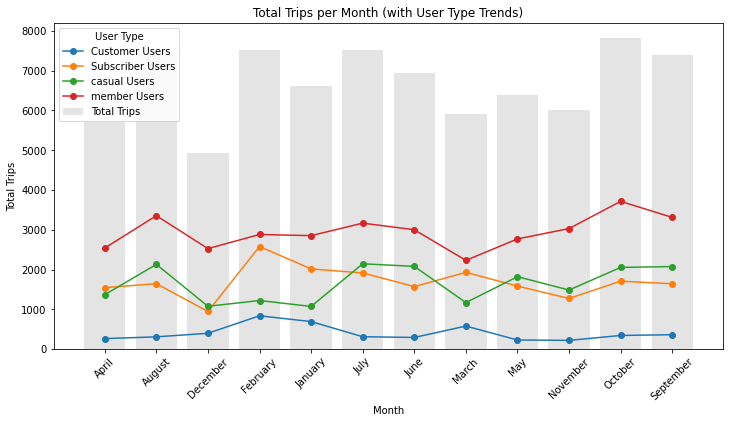

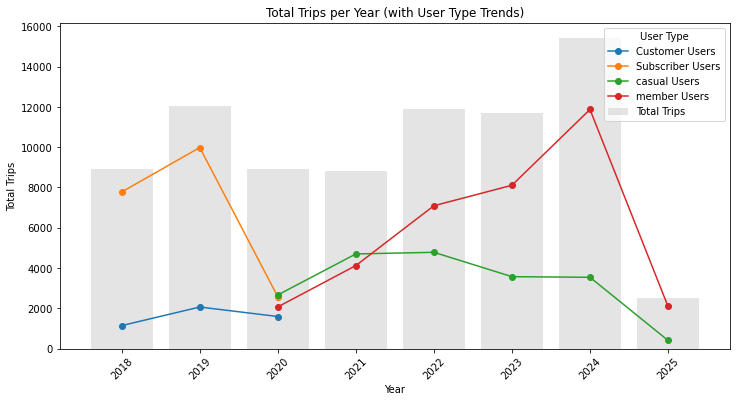

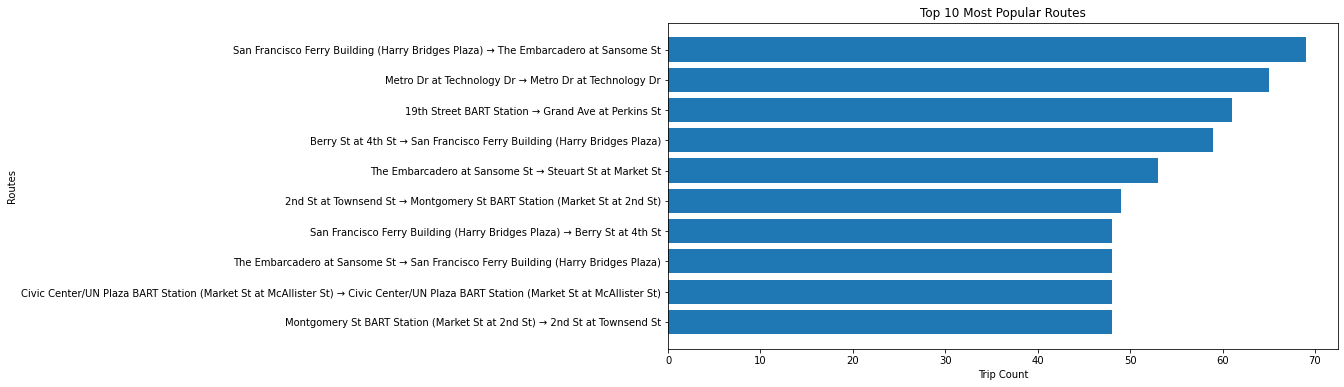

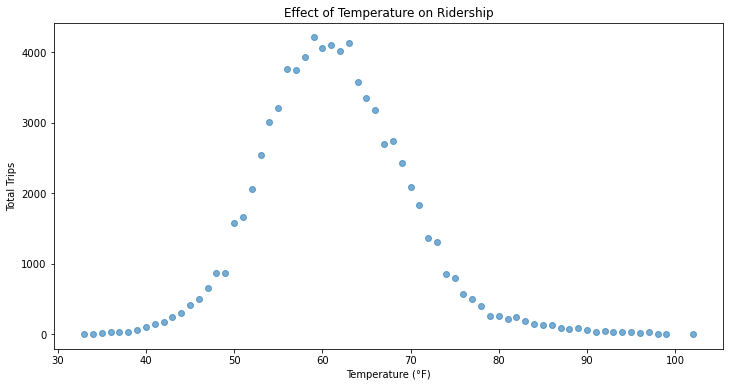

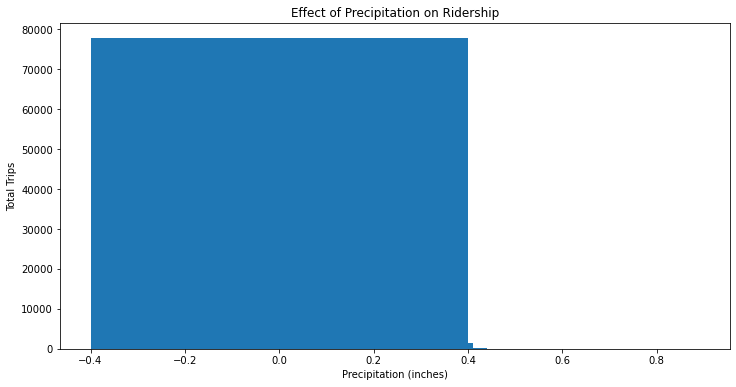

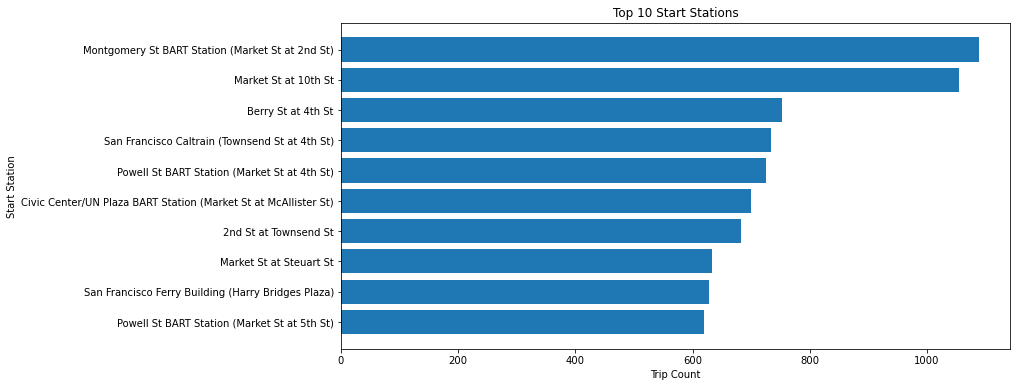

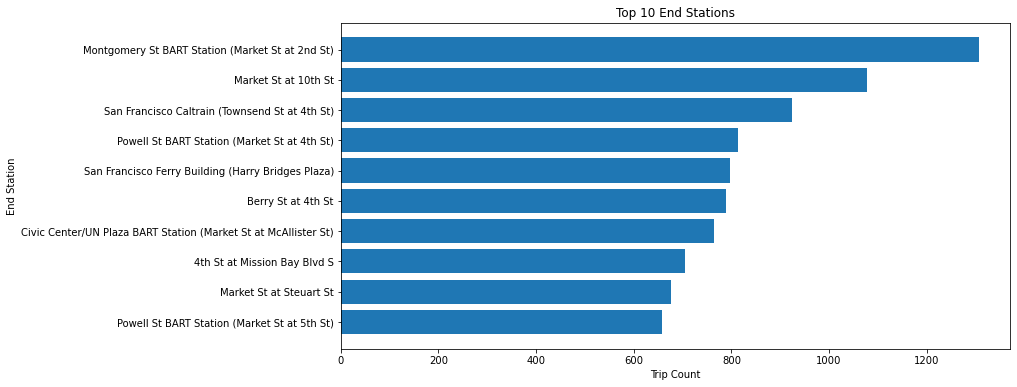

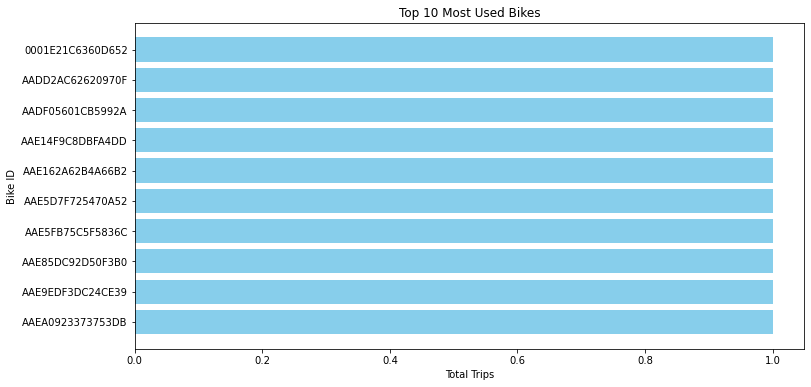

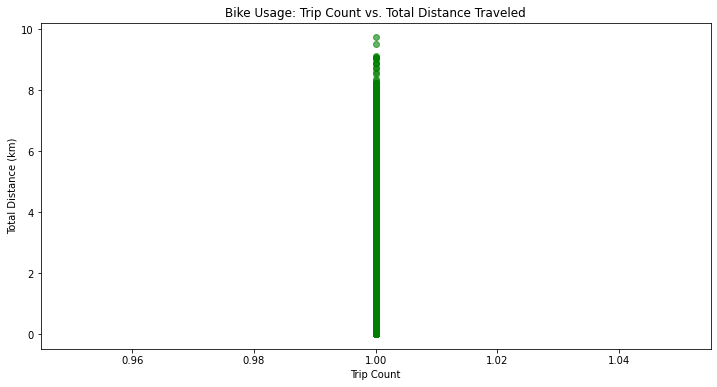

In [416]:

# ============================
# 1️⃣ High-Level Overview
# ============================

# 1A. Total trips per month with trend lines for user types
monthly_trips = merged_df.groupby(['month_name']).size().reset_index(name='trip_count')
user_type_trends = merged_df.groupby(['month_name', 'member_casual']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
plt.bar(monthly_trips['month_name'], monthly_trips['trip_count'], color='lightgray', alpha=0.6, label="Total Trips")
for user_type in user_type_trends['member_casual'].unique():
    subset = user_type_trends[user_type_trends['member_casual'] == user_type]
    plt.plot(subset['month_name'], subset['trip_count'], marker='o', label=f"{user_type} Users")
plt.xlabel("Month")
plt.ylabel("Total Trips")
plt.title("Total Trips per Month (with User Type Trends)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# 1B. Total trips per year with user type breakdown
yearly_trips = merged_df.groupby(merged_df['started_at'].dt.year).size().reset_index(name='trip_count')
yearly_trips_user = merged_df.groupby([merged_df['started_at'].dt.year, 'member_casual']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
plt.bar(yearly_trips['started_at'], yearly_trips['trip_count'], color='lightgray', alpha=0.6, label="Total Trips")
for user_type in yearly_trips_user['member_casual'].unique():
    subset = yearly_trips_user[yearly_trips_user['member_casual'] == user_type]
    plt.plot(subset['started_at'], subset['trip_count'], marker='o', label=f"{user_type} Users")
plt.xlabel("Year")
plt.ylabel("Total Trips")
plt.title("Total Trips per Year (with User Type Trends)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# 1C. Popular Routes (Top 10 most frequent routes)
popular_routes = merged_df.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='trip_count')
popular_routes = popular_routes.sort_values(by='trip_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(popular_routes.apply(lambda x: f"{x['start_station_name']} → {x['end_station_name']}", axis=1), popular_routes['trip_count'])
plt.xlabel("Trip Count")
plt.ylabel("Routes")
plt.title("Top 10 Most Popular Routes")
plt.gca().invert_yaxis()
plt.show()

# 1D. Weather Impact - Temperature vs. Total Trips
temp_impact = merged_df.groupby(['temp_f']).size().reset_index(name='trip_count')
plt.figure(figsize=(12, 6))
plt.scatter(temp_impact['temp_f'], temp_impact['trip_count'], alpha=0.6)
plt.xlabel("Temperature (°F)")
plt.ylabel("Total Trips")
plt.title("Effect of Temperature on Ridership")
plt.show()

# 1E. Weather Impact - Precipitation vs. Total Trips
precip_impact = merged_df.groupby(['precip_in']).size().reset_index(name='trip_count')
plt.figure(figsize=(12, 6))
plt.bar(precip_impact['precip_in'], precip_impact['trip_count'])
plt.xlabel("Precipitation (inches)")
plt.ylabel("Total Trips")
plt.title("Effect of Precipitation on Ridership")
plt.show()

# 1F. Top Start Stations
top_start_stations = merged_df.groupby('start_station_name').size().reset_index(name='trip_count')
top_start_stations = top_start_stations.sort_values(by='trip_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_start_stations['start_station_name'], top_start_stations['trip_count'])
plt.xlabel("Trip Count")
plt.ylabel("Start Station")
plt.title("Top 10 Start Stations")
plt.gca().invert_yaxis()
plt.show()

# 1G. Top End Stations
top_end_stations = merged_df.groupby('end_station_name').size().reset_index(name='trip_count')
top_end_stations = top_end_stations.sort_values(by='trip_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_end_stations['end_station_name'], top_end_stations['trip_count'])
plt.xlabel("Trip Count")
plt.ylabel("End Station")
plt.title("Top 10 End Stations")
plt.gca().invert_yaxis()
plt.show()


# ============================
# 2️⃣ Bike Usage Analysis
# ============================

# Ensure ride distance is computed using Haversine formula


def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c  # Distance in km

merged_df['ride_distance_km'] = merged_df.apply(
    lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng'])
    if not (pd.isna(row['start_lat']) or pd.isna(row['start_lng']) or pd.isna(row['end_lat']) or pd.isna(row['end_lng']))
    else None,
    axis=1
)

# 2A. Bike Usage Analysis (Trip Counts and Distance Covered)
bike_usage = merged_df.groupby('ride_id').agg(
    trip_count=('ride_id', 'size'),
    total_distance=('ride_distance_km', 'sum')
).reset_index()

# 2B. Top 10 Most Used Bikes
top_bikes = bike_usage.sort_values('trip_count', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.barh(top_bikes['ride_id'], top_bikes['trip_count'], color='skyblue')
plt.xlabel("Total Trips")
plt.ylabel("Bike ID")
plt.title("Top 10 Most Used Bikes")
plt.gca().invert_yaxis()
plt.show()

# 2C. Bike Usage: Trip Count vs. Total Distance
plt.figure(figsize=(12, 6))
plt.scatter(bike_usage['trip_count'], bike_usage['total_distance'], alpha=0.6, color='green')
plt.xlabel("Trip Count")
plt.ylabel("Total Distance (km)")
plt.title("Bike Usage: Trip Count vs. Total Distance Traveled")
plt.show()


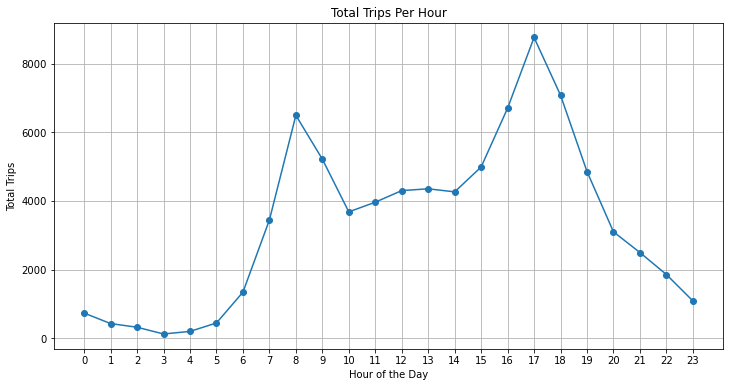

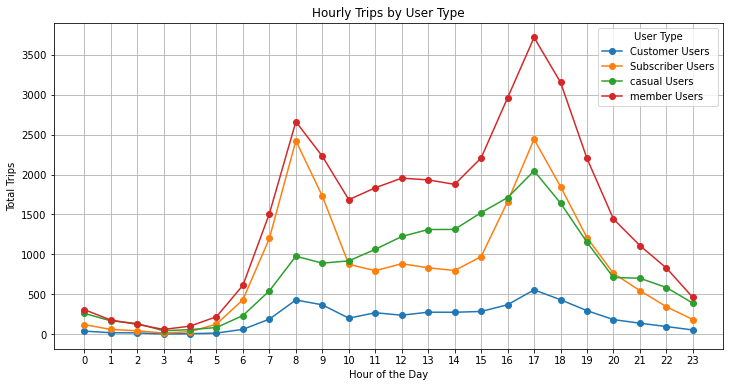

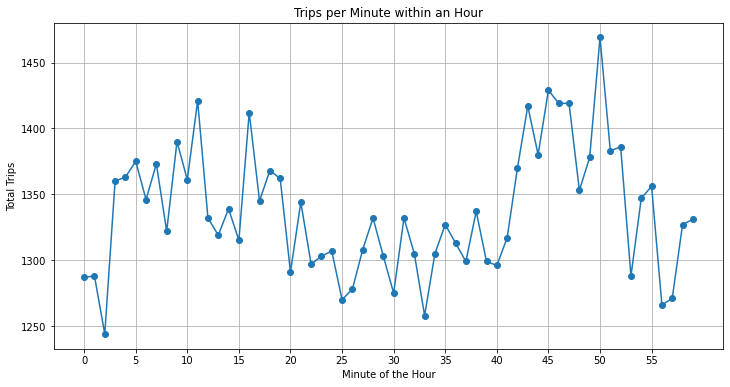

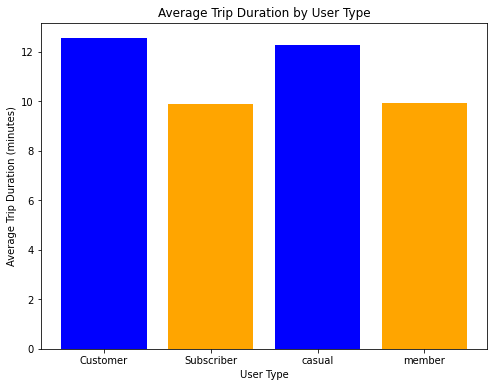

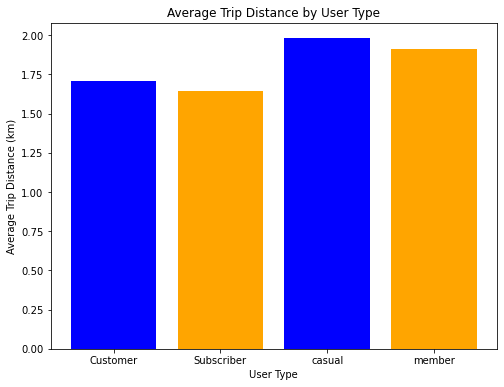

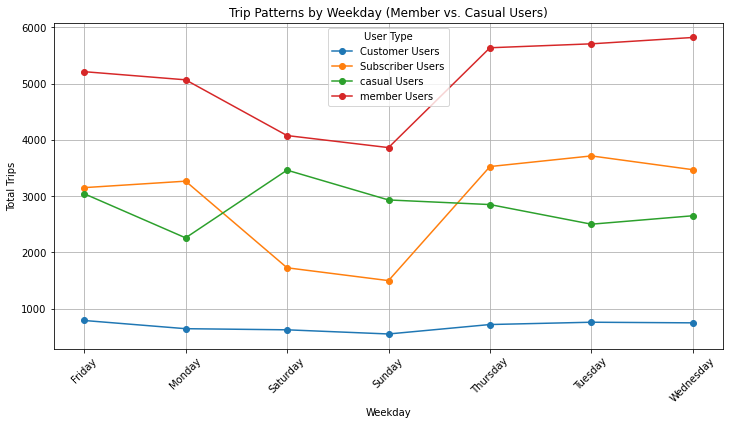

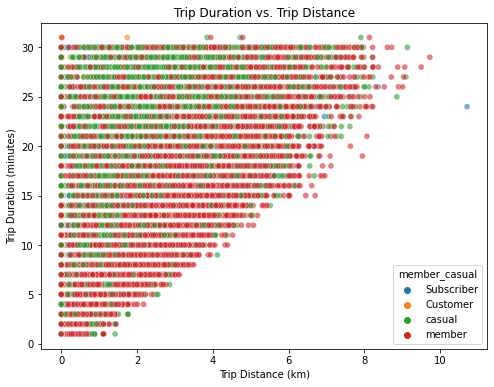

<Figure size 864x432 with 0 Axes>

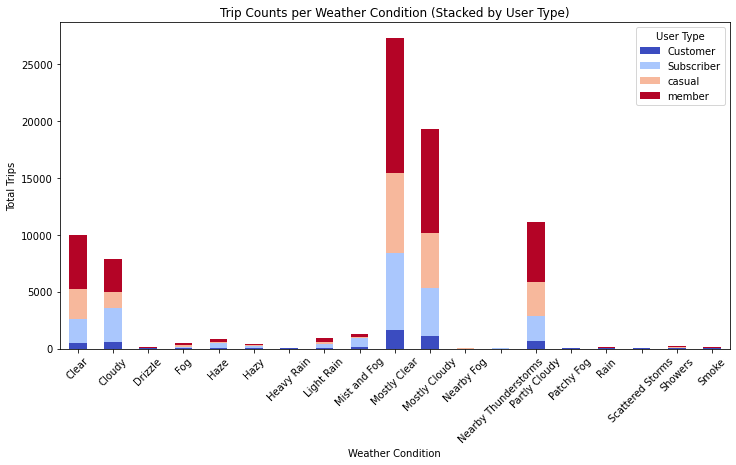

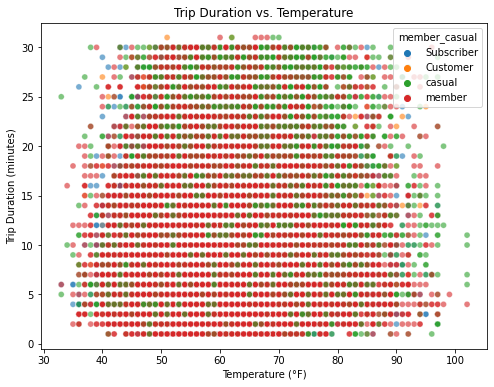

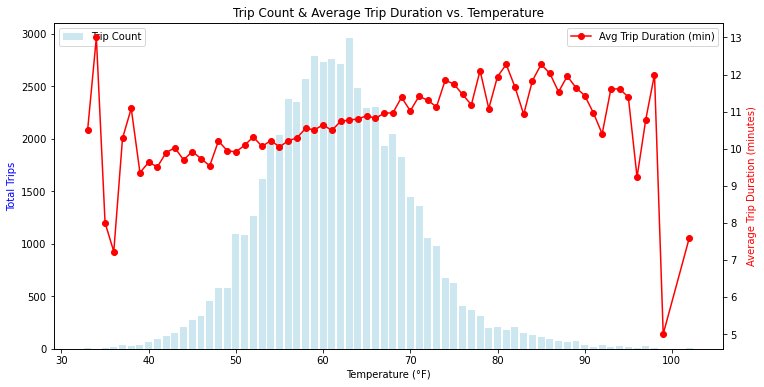

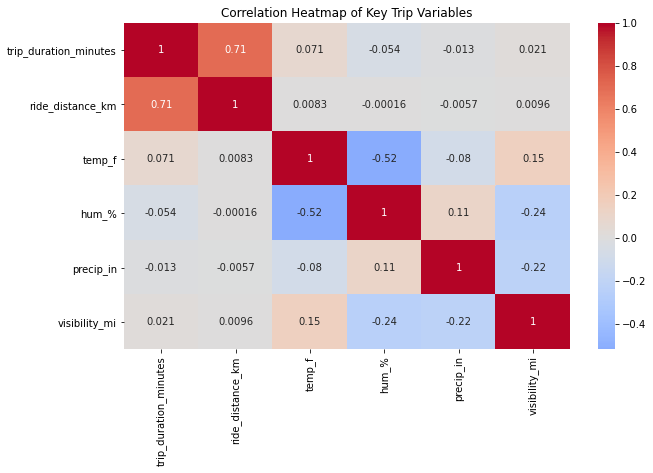

<Figure size 864x432 with 0 Axes>

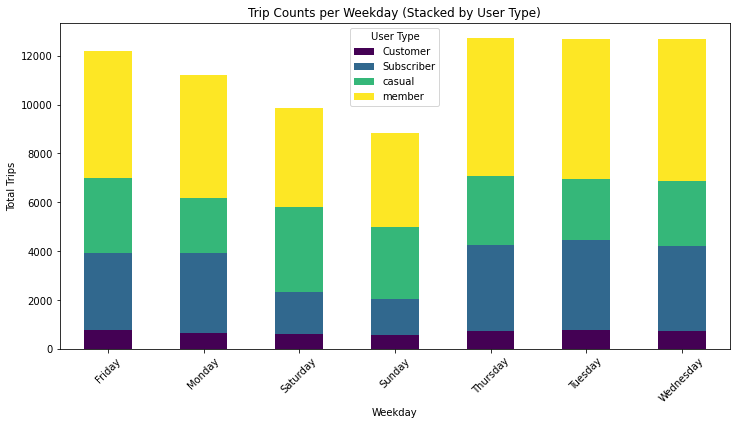

<Figure size 864x432 with 0 Axes>

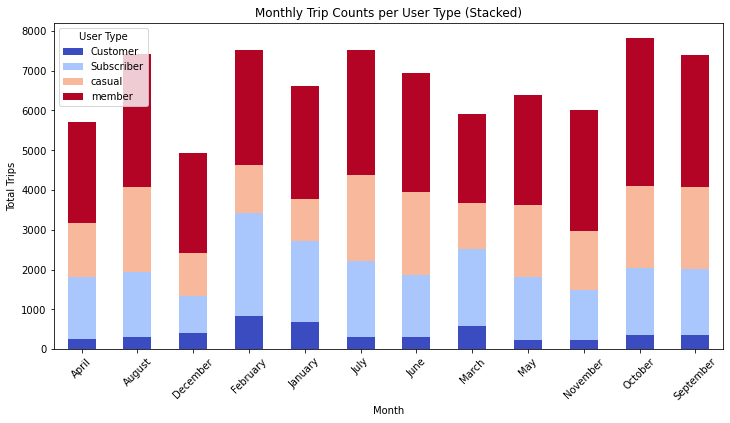

<Figure size 864x432 with 0 Axes>

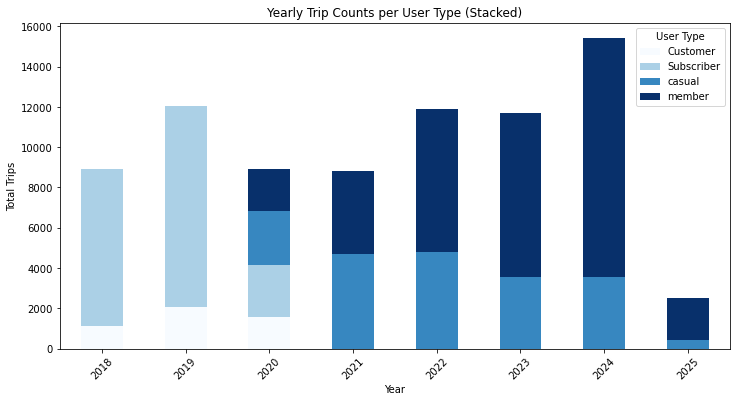

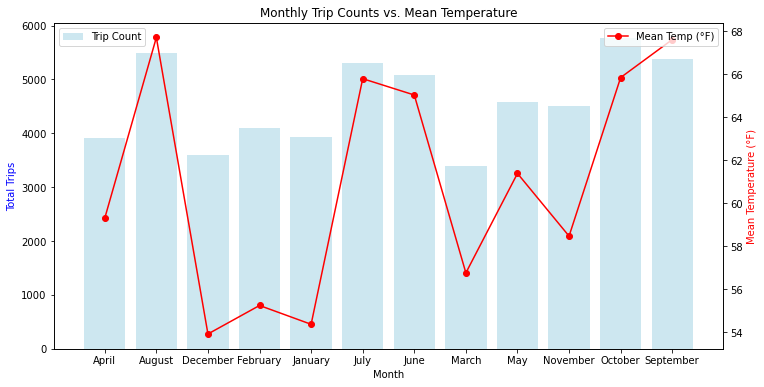

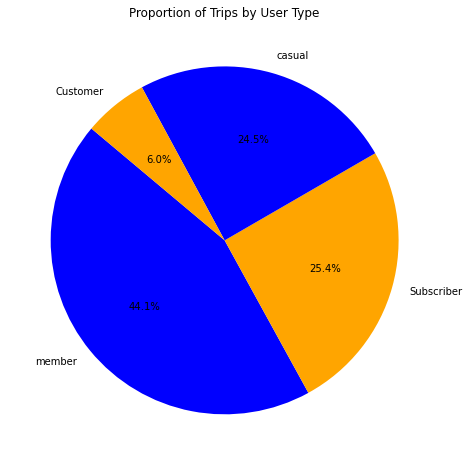

In [430]:

# ============================
# 1️⃣ Hourly & Minute-Level Trends
# ============================

# 1A. Trips per Hour (Aggregated across all days)
hourly_trips = merged_df.groupby(merged_df['started_at'].dt.hour).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
plt.plot(hourly_trips['started_at'], hourly_trips['trip_count'], marker='o', linestyle='-')
plt.xlabel("Hour of the Day")
plt.ylabel("Total Trips")
plt.title("Total Trips Per Hour")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

# 1B. Trips per Hour by User Type
hourly_trips_user = merged_df.groupby([merged_df['started_at'].dt.hour, 'member_casual']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
for user_type in hourly_trips_user['member_casual'].unique():
    subset = hourly_trips_user[hourly_trips_user['member_casual'] == user_type]
    plt.plot(subset['started_at'], subset['trip_count'], marker='o', linestyle='-', label=f"{user_type} Users")

plt.xlabel("Hour of the Day")
plt.ylabel("Total Trips")
plt.title("Hourly Trips by User Type")
plt.xticks(range(0, 24))
plt.legend(title="User Type")
plt.grid()
plt.show()

# 1C. Minute-Level Analysis (Aggregating per minute within an hour)
minute_trips = merged_df.groupby(merged_df['started_at'].dt.minute).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
plt.plot(minute_trips['started_at'], minute_trips['trip_count'], marker='o', linestyle='-')
plt.xlabel("Minute of the Hour")
plt.ylabel("Total Trips")
plt.title("Trips per Minute within an Hour")
plt.xticks(range(0, 60, 5))
plt.grid()
plt.show()

# ============================
# 2️⃣ User Behavior Exploration
# ============================

# 2A. Trip Duration by User Type
trip_duration_user = merged_df.groupby('member_casual')['trip_duration_minutes'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(trip_duration_user['member_casual'], trip_duration_user['trip_duration_minutes'], color=['blue', 'orange'])
plt.xlabel("User Type")
plt.ylabel("Average Trip Duration (minutes)")
plt.title("Average Trip Duration by User Type")
plt.show()

# 2B. Trip Distance by User Type
trip_distance_user = merged_df.groupby('member_casual')['ride_distance_km'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(trip_distance_user['member_casual'], trip_distance_user['ride_distance_km'], color=['blue', 'orange'])
plt.xlabel("User Type")
plt.ylabel("Average Trip Distance (km)")
plt.title("Average Trip Distance by User Type")
plt.show()

# 2C. Trip Patterns by Weekday vs. Weekend
merged_df['weekday_name'] = merged_df['started_at'].dt.day_name()
weekday_trips = merged_df.groupby(['weekday_name', 'member_casual']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
for user_type in weekday_trips['member_casual'].unique():
    subset = weekday_trips[weekday_trips['member_casual'] == user_type]
    plt.plot(subset['weekday_name'], subset['trip_count'], marker='o', linestyle='-', label=f"{user_type} Users")

plt.xlabel("Weekday")
plt.ylabel("Total Trips")
plt.title("Trip Patterns by Weekday (Member vs. Casual Users)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# ============================
# 3️⃣ Correlation Analysis
# ============================



# 3A. Trip Duration vs. Distance
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='ride_distance_km', y='trip_duration_minutes', hue='member_casual', alpha=0.6)
plt.xlabel("Trip Distance (km)")
plt.ylabel("Trip Duration (minutes)")
plt.title("Trip Duration vs. Trip Distance")
plt.show()

# ============================
# 1️⃣ Trip Count vs. Temperature (Stacked Bar Chart)
# ============================

# Trip Counts per Weather Condition (Stacked Bar Chart)
weather_trip_count = merged_df.groupby(['Weather', 'member_casual']).size().unstack()

plt.figure(figsize=(12, 6))
weather_trip_count.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))
plt.xlabel("Weather Condition")
plt.ylabel("Total Trips")
plt.title("Trip Counts per Weather Condition (Stacked by User Type)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# Trip Duration vs. Temperature (Scatter Plot)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='temp_f', y='trip_duration_minutes', hue='member_casual', alpha=0.6)
plt.xlabel("Temperature (°F)")
plt.ylabel("Trip Duration (minutes)")
plt.title("Trip Duration vs. Temperature")
plt.show()

# ============================
# 2️⃣ Dual-Axis Chart: Trip Count & Trip Duration vs. Temperature
# ============================

# Aggregate trip count and average trip duration per temperature
trip_analysis_temp = merged_df.groupby('temp_f').agg(
    trip_count=('ride_id', 'count'),  # Count of rides at each temperature
    avg_trip_duration=('trip_duration_minutes', 'mean')  # Average trip duration at each temperature
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for trip count
ax1.bar(trip_analysis_temp['temp_f'], trip_analysis_temp['trip_count'], color='lightblue', alpha=0.6, label="Trip Count")
ax1.set_xlabel("Temperature (°F)")
ax1.set_ylabel("Total Trips", color='blue')

# Line plot for average trip duration
ax2 = ax1.twinx()
ax2.plot(trip_analysis_temp['temp_f'], trip_analysis_temp['avg_trip_duration'], color='red', marker='o', label="Avg Trip Duration (min)")
ax2.set_ylabel("Average Trip Duration (minutes)", color='red')

plt.title("Trip Count & Average Trip Duration vs. Temperature")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# 3C. Correlation Heatmap (Key Variables)
correlation_columns = ['trip_duration_minutes', 'ride_distance_km', 'temp_f', 'hum_%', 'precip_in', 'visibility_mi']
corr_matrix = merged_df[correlation_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Key Trip Variables")
plt.show()

# ============================
# 5️⃣ Weekly, Monthly & Yearly Trends
# ============================

# Weekday Name vs. Trip Counts (Stacked Bar Chart)
merged_df['weekday_name'] = merged_df['started_at'].dt.day_name()
weekday_trips = merged_df.groupby(['weekday_name', 'member_casual']).size().unstack()

plt.figure(figsize=(12, 6))
weekday_trips.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.xlabel("Weekday")
plt.ylabel("Total Trips")
plt.title("Trip Counts per Weekday (Stacked by User Type)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# Monthly Trip Counts vs. User Type (Stacked Bar Chart)
monthly_trips = merged_df.groupby(['month_name', 'member_casual']).size().unstack()

plt.figure(figsize=(12, 6))
monthly_trips.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))
plt.xlabel("Month")
plt.ylabel("Total Trips")
plt.title("Monthly Trip Counts per User Type (Stacked)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# Yearly Trip Counts vs. User Type (Stacked Bar Chart)
yearly_trips = merged_df.groupby([merged_df['started_at'].dt.year, 'member_casual']).size().unstack()

plt.figure(figsize=(12, 6))
yearly_trips.plot(kind='bar', stacked=True, colormap='Blues', figsize=(12, 6))
plt.xlabel("Year")
plt.ylabel("Total Trips")
plt.title("Yearly Trip Counts per User Type (Stacked)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# Monthly Trip Counts vs. Mean Temperature (Dual-Axis Chart)
monthly_trip_temp = merged_df.groupby(['month_name']).agg(
    trip_count=('ride_id', 'count'),
    mean_temp=('temp_f', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(monthly_trip_temp['month_name'], monthly_trip_temp['trip_count'], color='lightblue', alpha=0.6, label="Trip Count")
ax1.set_xlabel("Month")
ax1.set_ylabel("Total Trips", color='blue')

ax2 = ax1.twinx()
ax2.plot(monthly_trip_temp['month_name'], monthly_trip_temp['mean_temp'], color='red', marker='o', label="Mean Temp (°F)")
ax2.set_ylabel("Mean Temperature (°F)", color='red')

plt.title("Monthly Trip Counts vs. Mean Temperature")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# ============================
# 6️⃣ Pie Chart: User Type Distribution
# ============================

user_counts = merged_df['member_casual'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(user_counts, labels=user_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'orange'])
plt.title("Proportion of Trips by User Type")
plt.show()


<Figure size 864x432 with 0 Axes>

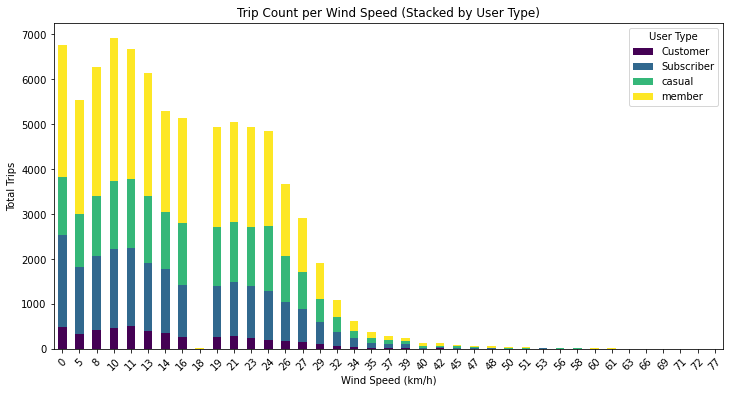

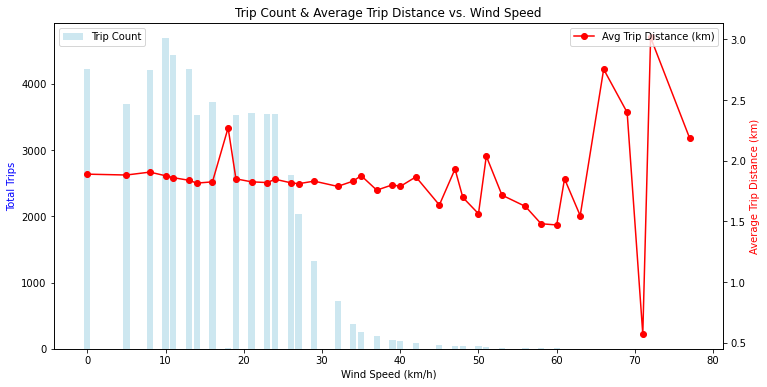

<Figure size 864x432 with 0 Axes>

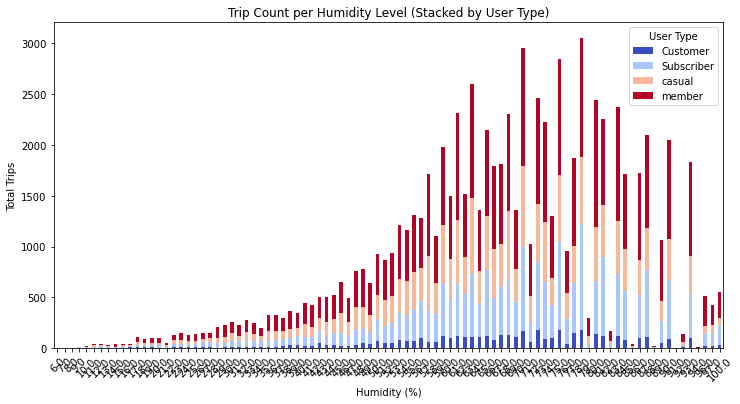

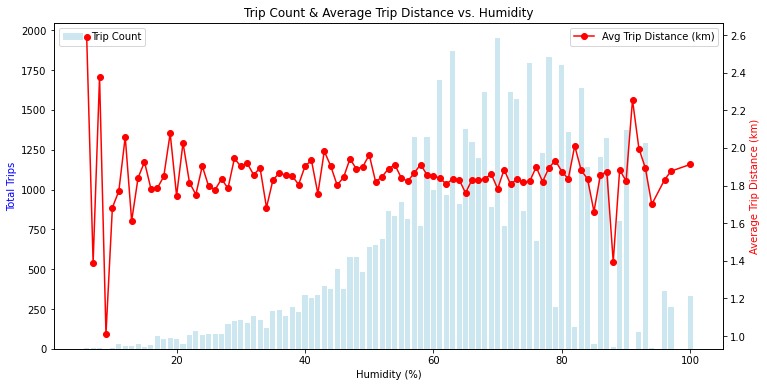

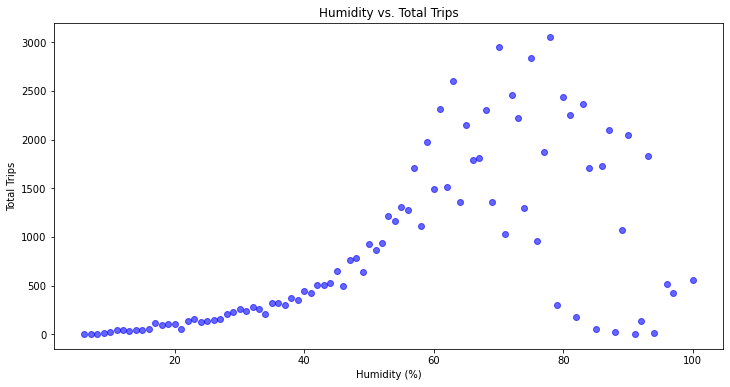

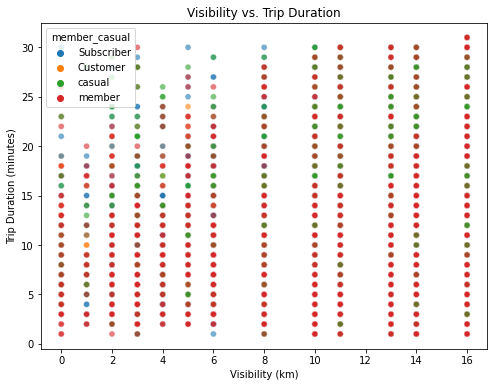

In [431]:
# ============================
# 1️⃣ Wind Speed vs. Trip Count (Stacked Bar Chart)
# ============================

wind_speed_trip_count = merged_df.groupby(['wind_speed_kmh', 'member_casual']).size().unstack()

plt.figure(figsize=(12, 6))
wind_speed_trip_count.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.xlabel("Wind Speed (km/h)")
plt.ylabel("Total Trips")
plt.title("Trip Count per Wind Speed (Stacked by User Type)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# ============================
# 2️⃣ Dual-Axis Chart: Trip Count & Trip Distance vs. Wind Speed
# ============================

# Aggregate trip count and average trip distance per wind speed
trip_analysis_wind = merged_df.groupby('wind_speed_kmh').agg(
    trip_count=('ride_id', 'count'),  # Count of rides at each wind speed
    avg_trip_distance=('ride_distance_km', 'mean')  # Average trip distance at each wind speed
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for trip count
ax1.bar(trip_analysis_wind['wind_speed_kmh'], trip_analysis_wind['trip_count'], color='lightblue', alpha=0.6, label="Trip Count")
ax1.set_xlabel("Wind Speed (km/h)")
ax1.set_ylabel("Total Trips", color='blue')

# Line plot for average trip distance
ax2 = ax1.twinx()
ax2.plot(trip_analysis_wind['wind_speed_kmh'], trip_analysis_wind['avg_trip_distance'], color='red', marker='o', label="Avg Trip Distance (km)")
ax2.set_ylabel("Average Trip Distance (km)", color='red')

plt.title("Trip Count & Average Trip Distance vs. Wind Speed")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# ============================
# 3️⃣ Humidity vs. Trip Count (Stacked Bar Chart)
# ============================

humidity_trip_count = merged_df.groupby(['hum_%', 'member_casual']).size().unstack()

plt.figure(figsize=(12, 6))
humidity_trip_count.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))
plt.xlabel("Humidity (%)")
plt.ylabel("Total Trips")
plt.title("Trip Count per Humidity Level (Stacked by User Type)")
plt.legend(title="User Type")
plt.xticks(rotation=45)
plt.show()

# ============================
# 4️⃣ Dual-Axis Chart: Trip Count & Trip Distance vs. Humidity
# ============================

# Aggregate trip count and average trip distance per humidity level
trip_analysis_humidity = merged_df.groupby('hum_%').agg(
    trip_count=('ride_id', 'count'),  # Count of rides at each humidity level
    avg_trip_distance=('ride_distance_km', 'mean')  # Average trip distance at each humidity level
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for trip count
ax1.bar(trip_analysis_humidity['hum_%'], trip_analysis_humidity['trip_count'], color='lightblue', alpha=0.6, label="Trip Count")
ax1.set_xlabel("Humidity (%)")
ax1.set_ylabel("Total Trips", color='blue')

# Line plot for average trip distance
ax2 = ax1.twinx()
ax2.plot(trip_analysis_humidity['hum_%'], trip_analysis_humidity['avg_trip_distance'], color='red', marker='o', label="Avg Trip Distance (km)")
ax2.set_ylabel("Average Trip Distance (km)", color='red')

plt.title("Trip Count & Average Trip Distance vs. Humidity")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()



# ============================
# 2️⃣ Humidity vs. Ridership
# ============================

# Ensure 'hum_%' is numeric
merged_df['hum_%'] = merged_df['hum_%'].astype(str).str.replace("%", "", regex=False).str.strip().replace("", np.nan)
merged_df['hum_%'] = pd.to_numeric(merged_df['hum_%'], errors='coerce')

# Aggregate total trips by humidity level
humidity_impact = merged_df.groupby(['hum_%']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
plt.scatter(humidity_impact['hum_%'], humidity_impact['trip_count'], alpha=0.6, color='blue')
plt.xlabel("Humidity (%)")
plt.ylabel("Total Trips")
plt.title("Humidity vs. Total Trips")
plt.show()


# ============================
# 3️⃣ Visibility vs. Trip Duration
# ============================

plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='visibility_mi', y='trip_duration_minutes', hue='member_casual', alpha=0.6)
plt.xlabel("Visibility (km)")
plt.ylabel("Trip Duration (minutes)")
plt.title("Visibility vs. Trip Duration")
plt.show()



## Aggregating Data to Daily Level

In [433]:
merged_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,end_time,start_year,start_month,start_week_number,start_weekday,start_weekday_name,start_day,start_hour,start_minute,start_second,Weather,Pressure,trip_distance_km,trip_duration_seconds,trip_duration_minutes,trip_duration_hours,month_name,wind_direction,wind_speed_kmh,start_dock_count,start_neighborhood,start_station_kiosk_count,end_dock_count,end_neighborhood,end_station_kiosk_count,temp_f,precip_in,visibility_mi,dewpt_f,hum_%,ride_distance_km,weekday_name
0,<NA>,<NA>,2018-01-01 07:33:46,2018-01-01 07:57:05,Davis St at Jackson St,11,Davis St at Jackson St,11,37.797280,-122.398436,37.797280,-122.398436,Subscriber,07:33:46,07:57:05,2018,1,1,0,Monday,1,7,33,46,Mist and Fog,30.24,0.00,1399.0,23.0,0.0,January,NNE,10,35.0,Financial District/South Beach,True,35.0,Financial District/South Beach,True,40.0,0.0,8.0,40.0,100.0,0.000000,Monday
1,<NA>,<NA>,2018-01-01 11:16:25,2018-01-01 11:21:38,Townsend St at 7th St,90,Rhode Island St at 17th St,114,37.771058,-122.402717,37.764478,-122.402570,Subscriber,11:16:25,11:21:38,2018,1,1,0,Monday,1,11,16,25,Mist and Fog,30.26,0.73,313.0,5.0,0.0,January,SSW,5,27.0,South of Market,True,19.0,Potrero Hill,True,51.0,0.0,6.0,48.0,89.0,0.731743,Monday
2,<NA>,<NA>,2018-01-01 12:15:27,2018-01-01 12:34:57,San Francisco Ferry Building (Harry Bridges Pl...,15,The Embarcadero at Sansome St,6,37.795392,-122.394203,37.804770,-122.403234,Customer,12:15:27,12:34:57,2018,1,1,0,Monday,1,12,15,27,Mist and Fog,30.23,1.31,1170.0,20.0,0.0,January,WSW,8,38.0,Financial District/South Beach,True,23.0,Financial District/South Beach,True,52.0,0.0,6.0,48.0,86.0,1.310345,Monday
3,<NA>,<NA>,2018-01-01 18:52:58,2018-01-01 19:01:14,30th St at San Jose Ave,146,19th St at Mission St,122,37.742314,-122.423181,37.760299,-122.418892,Subscriber,18:52:58,19:01:14,2018,1,1,0,Monday,1,18,52,58,Mostly Cloudy,30.16,2.04,496.0,8.0,0.0,January,N,0,15.0,Bernal Heights,True,19.0,Mission,True,51.0,0.0,16.0,49.0,92.0,2.035084,Monday
4,<NA>,<NA>,2018-01-02 03:53:57,2018-01-02 03:59:15,San Pablo Ave at MLK Jr Way,220,Telegraph Ave at 19th St,183,37.811351,-122.273422,37.808702,-122.269927,Subscriber,03:53:57,03:59:15,2018,1,1,1,Tuesday,2,3,53,57,Cloudy,30.17,0.43,318.0,5.0,0.0,January,NE,10,19.0,<NA>,True,27.0,<NA>,True,45.0,0.0,16.0,42.0,90.0,0.425477,Tuesday


In [447]:
merged_df['member_casual'].unique()

<StringArray>
['Subscriber', 'Customer', 'casual', 'member']
Length: 4, dtype: string

In [456]:
# Extract 'start_date' from 'started_at' (removing time component)
merged_df['start_date'] = merged_df['started_at'].dt.date

# ============================
# 1️⃣ Daily Aggregation of Ride Data
# ============================

bike = merged_df.groupby('start_date').agg(
    count=('start_date', 'size'),             # Count of rides per day
    total_trip_duration_min=('trip_duration_minutes', 'sum'),  # Total trip duration in minutes
    total_trip_distance_km=('ride_distance_km', 'sum'),
    avg_temp_f=('temp_f', 'mean'),
    avg_humidity=('hum_%', 'mean'),
    total_precip_in=('precip_in', 'sum'),
    avg_visibility_mi=('visibility_mi', 'mean'),
).reset_index()

# Convert 'start_date' to datetime for time-series analysis
bike['day'] = pd.to_datetime(bike['start_date'])

# ============================
# 2️⃣ Compute Daily Mode for Weather Condition
# ============================

daily_weather_mode = merged_df.groupby('start_date')['Weather'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
).reset_index(name='weather')

# Merge the daily weather mode into the daily aggregated data.
bike = pd.merge(bike, daily_weather_mode, on='start_date', how='left')

# ============================
# 3️⃣ Aggregate Trip Counts by User Type
# ============================

user_type_counts = merged_df.groupby(['start_date', 'member_casual']).size().unstack(fill_value=0).reset_index()

# Merge user type counts with daily aggregated data
bike = pd.merge(bike, user_type_counts, on='start_date', how='left')

# Rename columns for clarity
bike.rename(columns={'casual': 'casual_count', 'member': 'member_count', 'Customer': 'customer_count', 'Subscriber': 'subscriber_count'}, inplace=True)

# Convert 'day' back to datetime for time-series analysis
bike['day'] = pd.to_datetime(bike['day'])

bike.head()


,start_date,count,total_trip_duration_min,total_trip_distance_km,avg_temp_f,avg_humidity,total_precip_in,avg_visibility_mi,day,weather,customer_count,subscriber_count,casual_count,member_count
0,2018-01-01,4,56.0,4.077172,48.500000,91.750000,0.00,9.000000,2018-01-01,Mist and Fog,1,3,0,0
1,2018-01-02,10,90.0,12.899217,52.100000,81.400000,0.00,13.400000,2018-01-02,Cloudy,0,10,0,0
2,2018-01-03,8,74.0,12.168368,50.375000,92.750000,0.04,6.750000,2018-01-03,Mist and Fog,3,5,0,0
3,2018-01-04,22,189.0,30.584660,57.727273,88.772727,0.00,13.181818,2018-01-04,Cloudy,1,21,0,0
4,2018-01-05,4,33.0,4.919441,57.500000,98.250000,0.11,8.500000,2018-01-05,Light Rain,0,4,0,0


### Running a few quick checks

In [1147]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   start_date               31 non-null     datetime64[ns]
 1   count                    31 non-null     int64         
 2   total_trip_duration_sec  31 non-null     int64         
 3   total_trip_distance_km   31 non-null     float64       
 4   avg_temp_f               31 non-null     float64       
 5   avg_humidity             31 non-null     float64       
 6   total_precip_in          31 non-null     float64       
 7   avg_visibility_mi        31 non-null     float64       
 8   day                      31 non-null     datetime64[ns]
 9   weather                  31 non-null     object        
 10  customer_count           31 non-null     int64         
 11  subscriber_count         31 non-null     int64         
dtypes: datetime64[ns](2), float64(5), int6

In [437]:
bike.describe()

,count,total_trip_duration_min,total_trip_distance_km,avg_temp_f,avg_humidity,total_precip_in,avg_visibility_mi,Customer,Subscriber,casual_count,member_count
count,2586.000000,2586.000000,2586.000000,2586.000000,2586.000000,2586.000000,2586.000000,2586.000000,2586.000000,2586.000000,2586.000000
mean,31.015855,330.097448,57.375645,60.734134,67.539117,0.018379,15.284391,1.860789,7.864656,7.611369,13.679041
std,14.047093,149.333370,28.419980,6.833520,12.404994,0.073659,1.713477,4.452799,13.693052,6.830425,13.410201
min,1.000000,7.000000,1.298284,44.173913,14.052632,0.000000,0.571429,0.000000,0.000000,0.000000,0.000000
25%,21.000000,221.000000,36.346027,55.584559,61.402273,0.000000,15.405134,0.000000,0.000000,0.000000,0.000000
50%,30.000000,322.000000,54.273716,60.516196,68.915015,0.000000,16.000000,0.000000,0.000000,8.000000,11.000000
75%,40.000000,423.000000,74.311286,65.305769,75.433261,0.000000,16.000000,2.000000,12.750000,12.000000,23.000000
max,102.000000,1139.000000,194.802820,92.320000,100.000000,0.970000,16.000000,44.000000,72.000000,35.000000,58.000000


In [438]:
#Inspecting for null values
bike.isnull().sum()

start_date                 0
count                      0
total_trip_duration_min    0
total_trip_distance_km     0
avg_temp_f                 0
avg_humidity               0
total_precip_in            0
avg_visibility_mi          0
day                        0
weather                    0
Customer                   0
Subscriber                 0
casual_count               0
member_count               0
dtype: int64

In [439]:
bike.isna().sum()

start_date                 0
count                      0
total_trip_duration_min    0
total_trip_distance_km     0
avg_temp_f                 0
avg_humidity               0
total_precip_in            0
avg_visibility_mi          0
day                        0
weather                    0
Customer                   0
Subscriber                 0
casual_count               0
member_count               0
dtype: int64

#### Data Cleaning and Preparation

In [457]:
#Extracting the day from the date column
bike['day']= pd.to_datetime(bike["start_date"],dayfirst=True).dt.day
bike['month']= pd.to_datetime(bike["start_date"],dayfirst=True).dt.month
bike['year']= pd.to_datetime(bike["start_date"],dayfirst=True).dt.year
bike['weekday']= pd.to_datetime(bike["start_date"],dayfirst=True).dt.weekday
bike.head()

,start_date,count,total_trip_duration_min,total_trip_distance_km,avg_temp_f,avg_humidity,total_precip_in,avg_visibility_mi,day,weather,customer_count,subscriber_count,casual_count,member_count,month,year,weekday
0,2018-01-01,4,56.0,4.077172,48.500000,91.750000,0.00,9.000000,1,Mist and Fog,1,3,0,0,1,2018,0
1,2018-01-02,10,90.0,12.899217,52.100000,81.400000,0.00,13.400000,2,Cloudy,0,10,0,0,1,2018,1
2,2018-01-03,8,74.0,12.168368,50.375000,92.750000,0.04,6.750000,3,Mist and Fog,3,5,0,0,1,2018,2
3,2018-01-04,22,189.0,30.584660,57.727273,88.772727,0.00,13.181818,4,Cloudy,1,21,0,0,1,2018,3
4,2018-01-05,4,33.0,4.919441,57.500000,98.250000,0.11,8.500000,5,Light Rain,0,4,0,0,1,2018,4


In [441]:
#Checking the values in all columns. 
bike.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [442]:
#Checking rest of the column values
bike.weekday.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [1106]:
# As we can see that weekday contains values from 0 to 6. 
# 1= Monday and 0= Sunday

In [458]:
# Converting numeric variables into categorical variables
bike["weekday"] = bike["weekday"].map({1:'Mon', 2:'Tue', 3:'Wed', 4:'Thur', 5:'Fri', 6:'Sat', 
                                   0:'Sun'})
bike["weekday"].value_counts()

Thur    370
Sun     370
Mon     370
Fri     369
Sat     369
Wed     369
Tue     369
Name: weekday, dtype: int64

In [459]:
bike.year.value_counts()

2024    366
2023    365
2021    365
2022    365
2018    365
2019    364
2020    337
2025     59
Name: year, dtype: int64

In [1111]:
#Lets add seasons to the data set. A quick search revealed the following:

# Spring: March, April, May
# Summer: June, July, August
# Autumn: September, October, November
# Winter: December, January, February

In [460]:
# Define conditions for each season.
conditions = [
    bike['month'].isin([3, 4, 5]),    # Spring: March, April, May
    bike['month'].isin([6, 7, 8]),    # Summer: June, July, August
    bike['month'].isin([9, 10, 11]),  # Autumn: September, October, November
    bike['month'].isin([12, 1, 2])    # Winter: December, January, February
]

# Define the corresponding season names.
season_values = ['Spring', 'Summer', 'Autumn', 'Winter']

# Use np.select to create the 'season' column.
bike['season'] = np.select(conditions, season_values, default='Unknown')

# Converting numeric variables into categorical variables
bike["month"] = bike["month"].map({1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
                                   7:'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})
bike["month"].value_counts()

# Preview the updated dataset with seasons.
print(bike[['month', 'season']].head())


     month  season
0  January  Winter
1  January  Winter
2  January  Winter
3  January  Winter
4  January  Winter


In [445]:
bike.weather.value_counts()

Mostly Clear     1012
Mostly Cloudy     729
Clear             264
Partly Cloudy     231
Cloudy            227
Light Rain         34
Mist and Fog       28
Haze               24
Hazy               14
Smoke               8
Fog                 7
Showers             3
Heavy Rain          3
Rain                1
Drizzle             1
Name: weather, dtype: int64

In [461]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2586 entries, 0 to 2585
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   start_date               2586 non-null   object 
 1   count                    2586 non-null   int64  
 2   total_trip_duration_min  2586 non-null   float64
 3   total_trip_distance_km   2586 non-null   float64
 4   avg_temp_f               2586 non-null   float64
 5   avg_humidity             2586 non-null   float64
 6   total_precip_in          2586 non-null   float64
 7   avg_visibility_mi        2586 non-null   float64
 8   day                      2586 non-null   int64  
 9   weather                  2586 non-null   object 
 10  customer_count           2586 non-null   int64  
 11  subscriber_count         2586 non-null   int64  
 12  casual_count             2586 non-null   int64  
 13  member_count             2586 non-null   int64  
 14  month                   

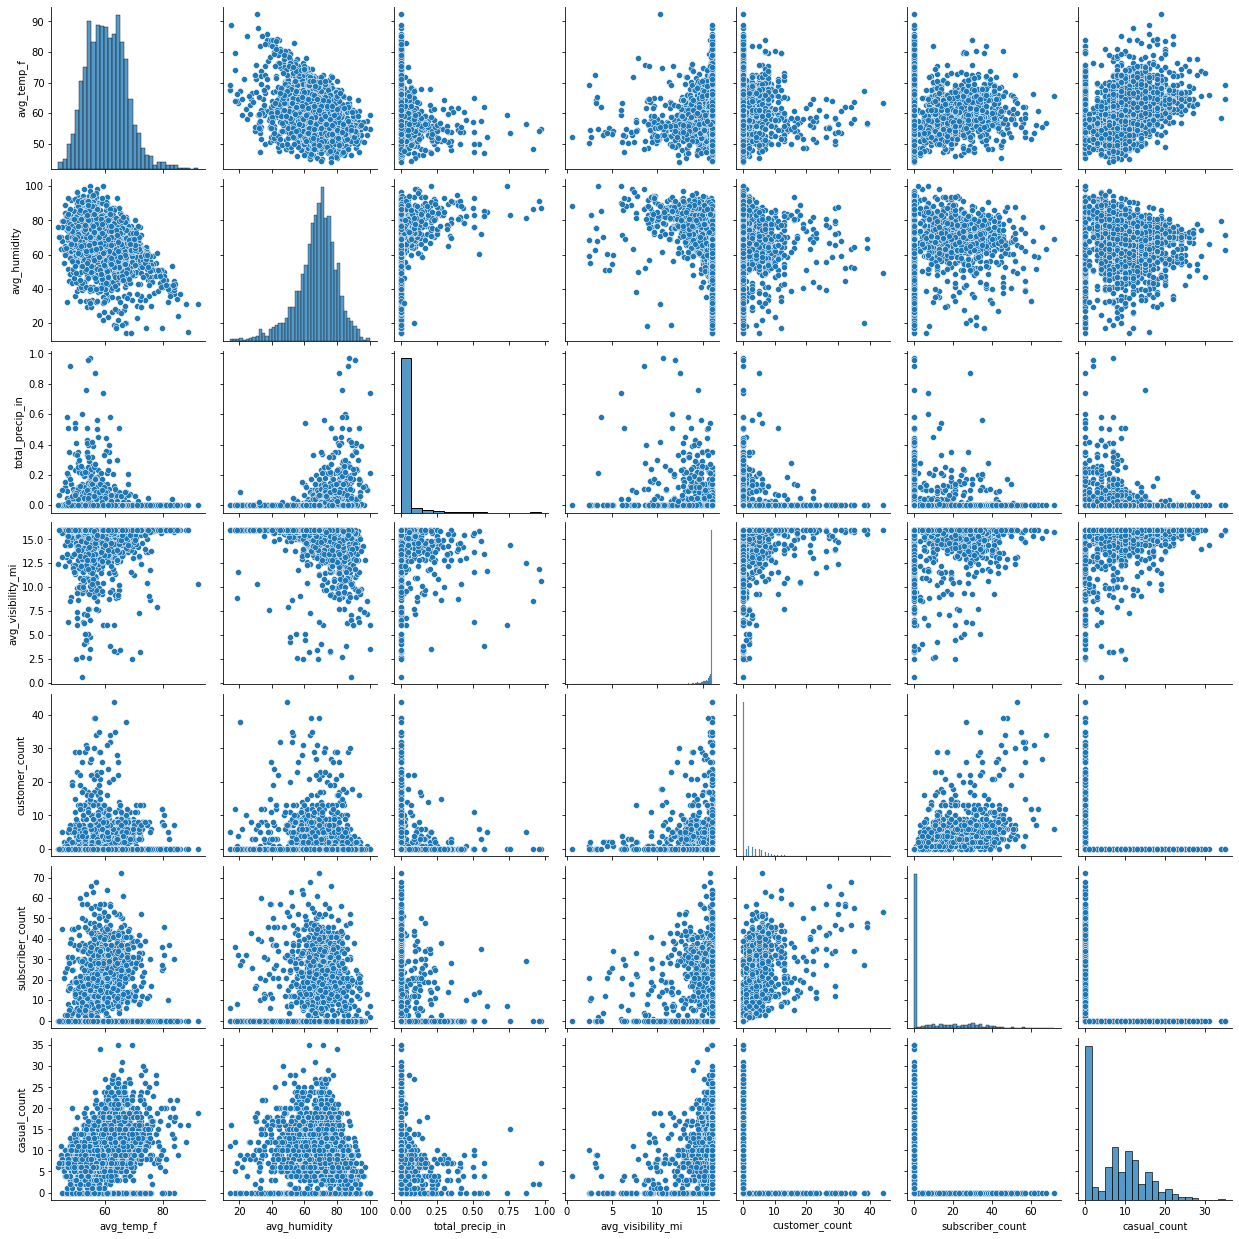

In [462]:
sns.pairplot(bike, vars=['avg_temp_f','avg_humidity','total_precip_in','avg_visibility_mi', 'customer_count', 'subscriber_count','casual_count'])
plt.show()

It can be seen that there are variable which have a positive linear relationship with each other.

In [1122]:
#We will be plotting categorical variables togther (Boxplots) and numeric variables to see trends and see
# if there are any outliers

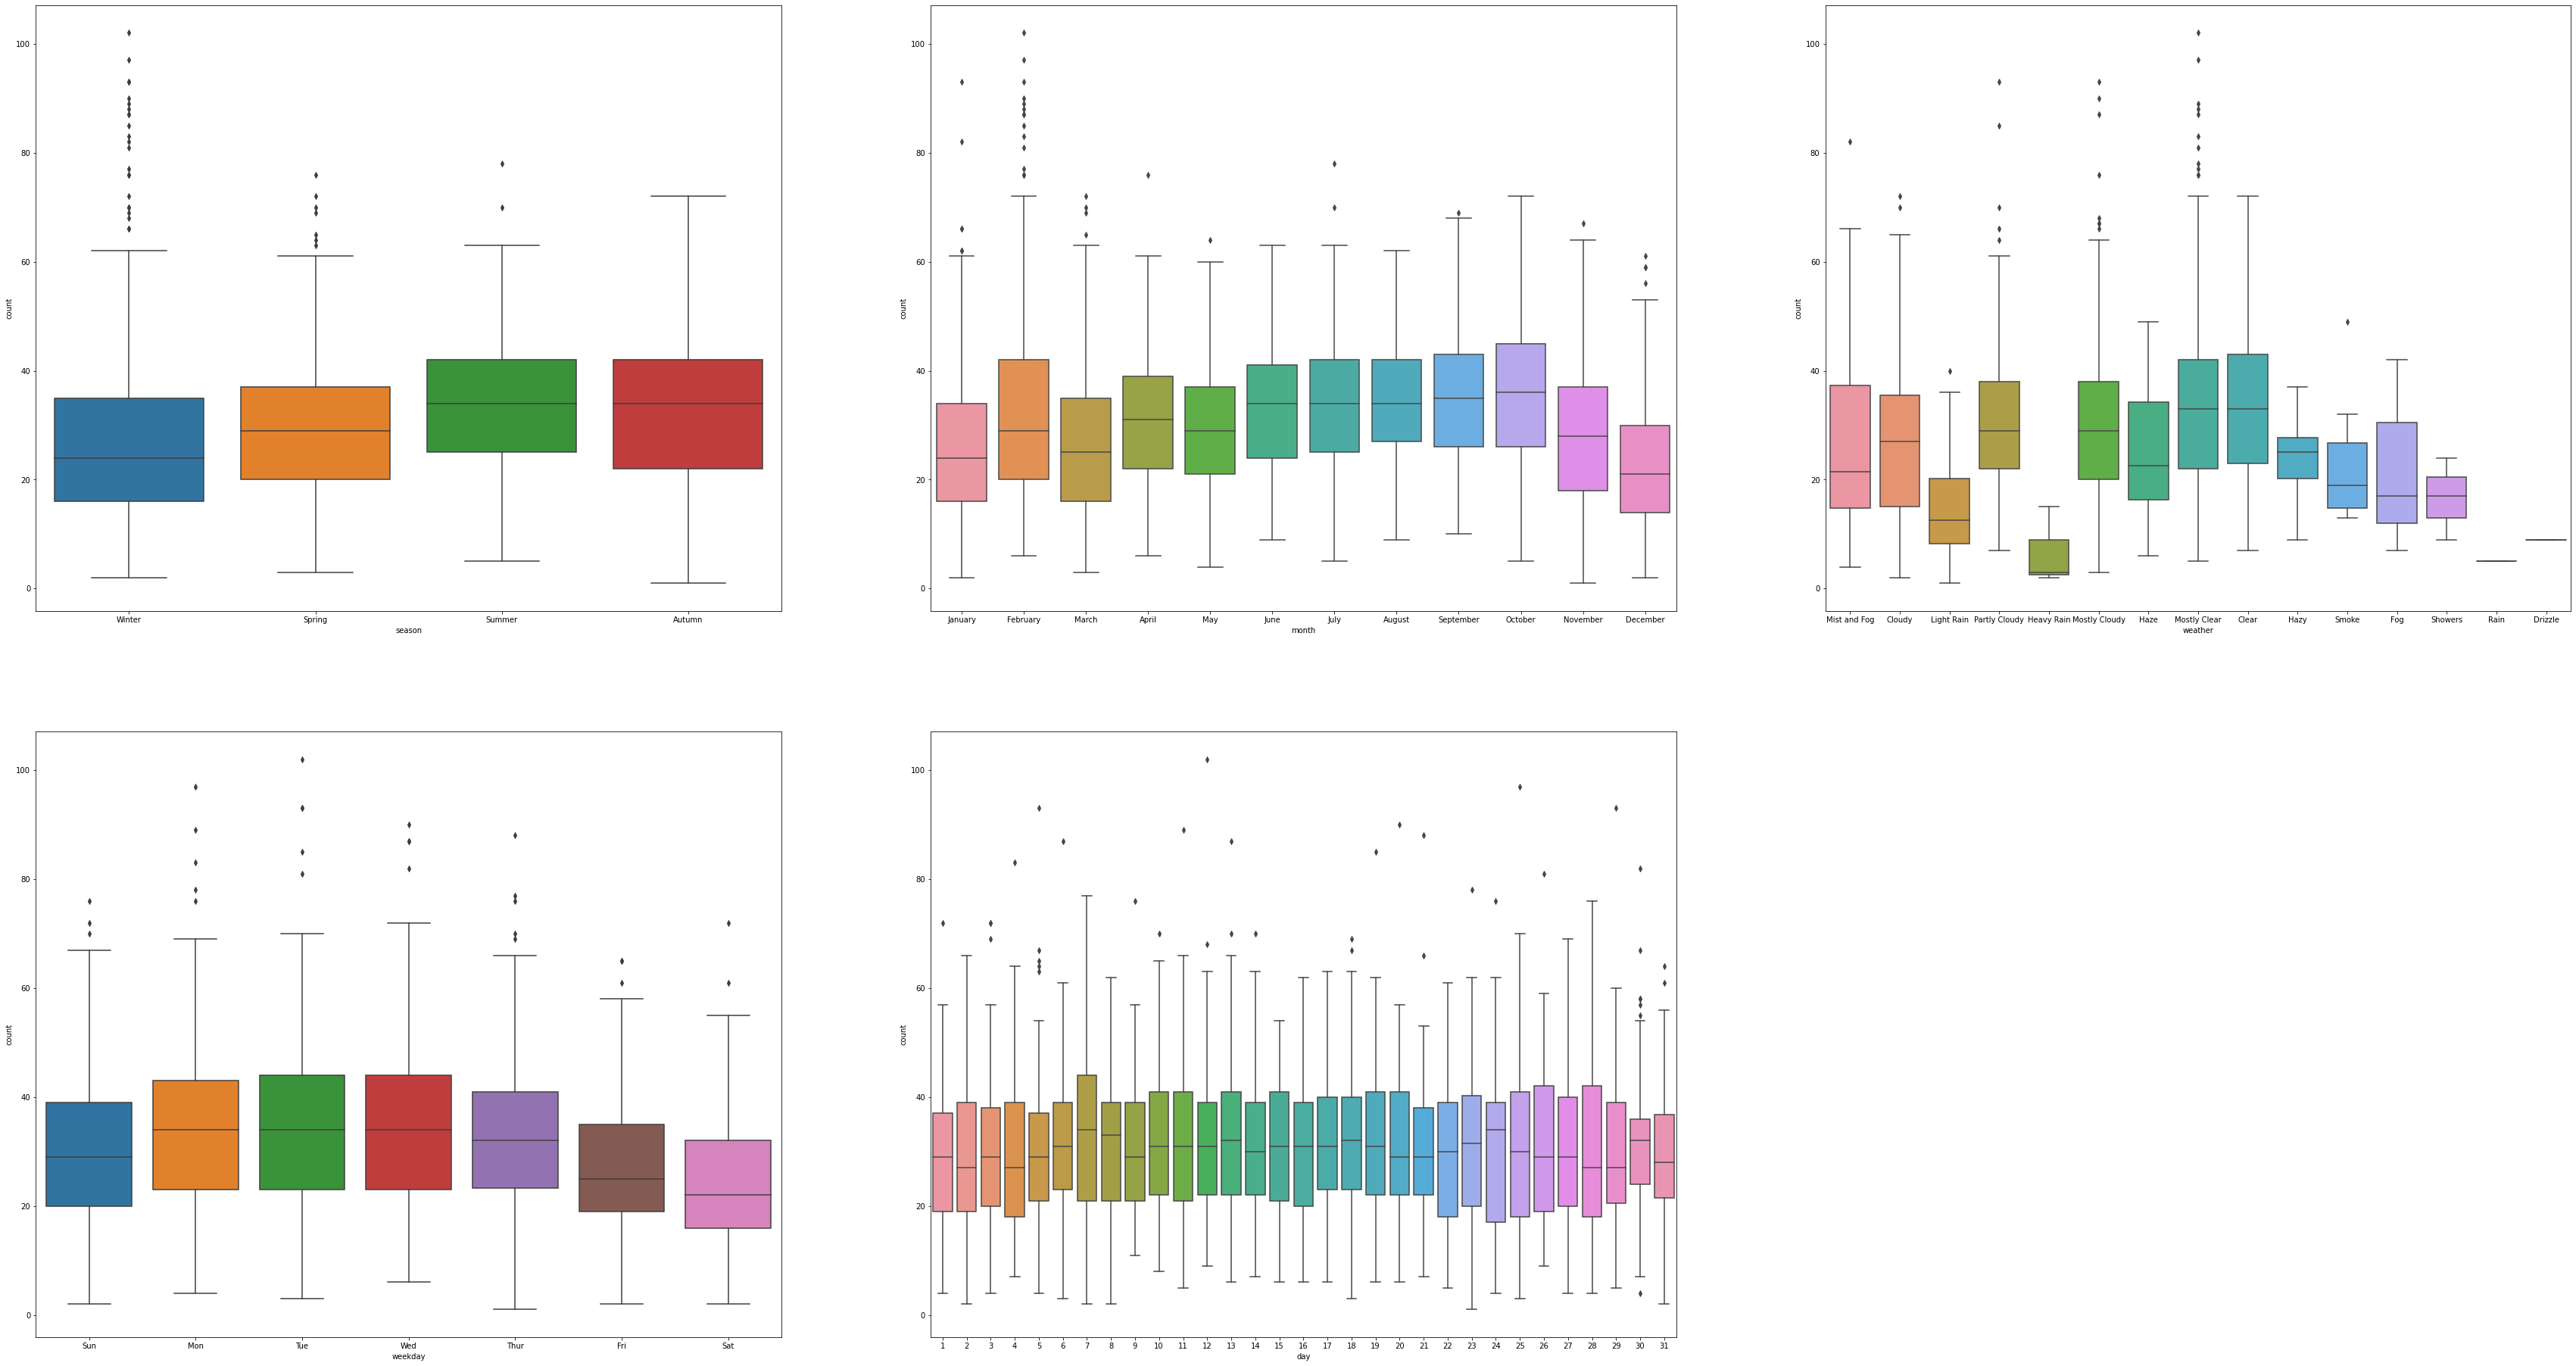

In [463]:
plt.figure(figsize=(60, 50))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'count', data = bike)
plt.subplot(3,3,2)
sns.boxplot(x = 'month', y = 'count', data = bike)
plt.subplot(3,3,3)
sns.boxplot(x = 'weather', y = 'count', data = bike)
plt.subplot(3,3,4)
sns.boxplot(x = 'weekday', y = 'count', data = bike)
plt.subplot(3,3,5)
sns.boxplot(x = 'day', y = 'count', data = bike)
plt.show()

In [1130]:
# Looking at individual factors which can possibly affect the count of bike sharing

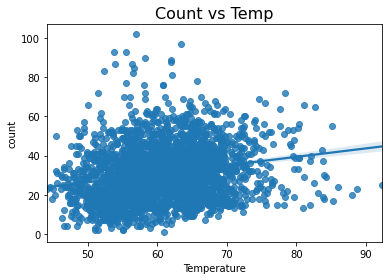

In [464]:
plt.title("Count vs Temp",fontsize=16)
sns.regplot(data=bike,y="count",x="avg_temp_f")
plt.xlabel("Temperature")
plt.show()

In [ ]:
# There is a negative linear correlation between count and temperature.
# As the temperature increases, the demand for bikes also increase

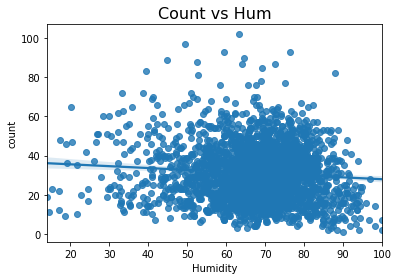

In [465]:
plt.title("Count vs Hum",fontsize=16)
sns.regplot(data=bike,y="count",x="avg_humidity")
plt.xlabel("Humidity")
plt.show()

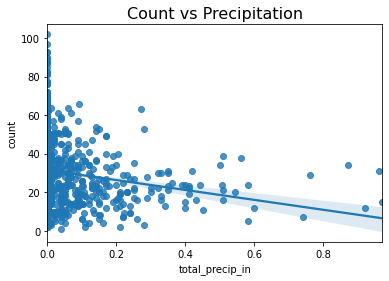

In [466]:
plt.title("Count vs Precipitation",fontsize=16)
sns.regplot(data=bike,y="count",x="total_precip_in")
plt.show()

In [ ]:
# The count of bikes show a decreasing trend with rise in Precipitation. 

In [ ]:
# Checking for correlation between categorical variables individually
# The categorical variables are: Month, Weekday, season and weather

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month', ylabel='customer_count'>

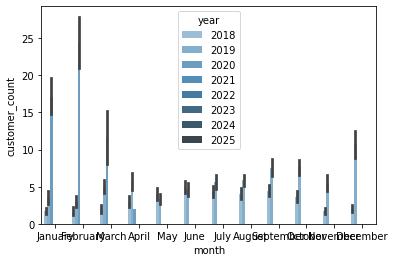

In [467]:
sns.barplot('month','customer_count', hue = 'year', data = bike, palette="Blues_d")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month', ylabel='subscriber_count'>

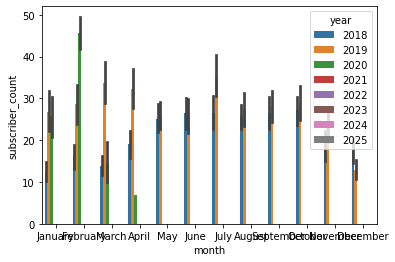

In [468]:
sns.barplot('month','subscriber_count', hue = 'year', data = bike)

<BarContainer object of 2586 artists>

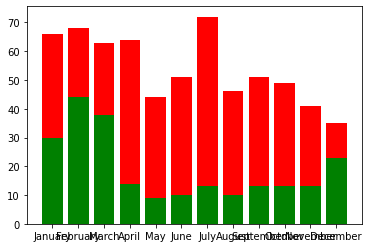

In [469]:
plt.bar(bike['month'], bike['subscriber_count'], label = 'Subscriber', color = 'r')
plt.bar(bike['month'], bike['customer_count'], label = 'Customer', color = 'g')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


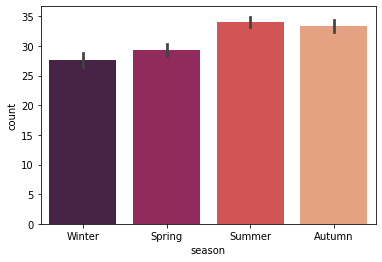

In [470]:
# Exploring dependencies of Count on different variables. 
sns.barplot('season','count',data=bike,palette="rocket",)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


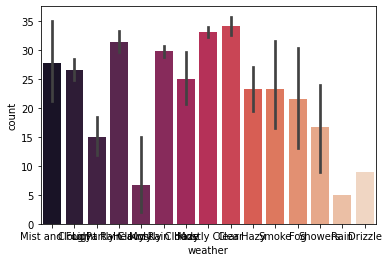

In [471]:
sns.barplot('weather','count',palette="rocket",data=bike)
plt.show()
           

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


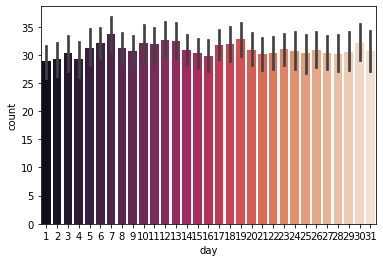

In [472]:
sns.barplot('day','count',palette="rocket",data=bike)
plt.show()
           

In [473]:
bike.corr()

,count,total_trip_duration_min,total_trip_distance_km,avg_temp_f,avg_humidity,total_precip_in,avg_visibility_mi,day,customer_count,subscriber_count,casual_count,member_count,year
count,1.000000,0.957664,0.956670,0.210619,-0.084030,-0.134999,0.179588,0.002752,0.327634,0.313449,0.220909,0.506124,0.310705
total_trip_duration_min,0.957664,1.000000,0.963739,0.277875,-0.126706,-0.165160,0.201523,0.007743,0.326094,0.272034,0.307301,0.460575,0.284866
total_trip_distance_km,0.956670,0.963739,1.000000,0.225749,-0.102682,-0.130225,0.197990,-0.001858,0.220754,0.157980,0.332105,0.598336,0.410302
avg_temp_f,0.210619,0.277875,0.225749,1.000000,-0.339880,-0.198282,0.152644,-0.015486,-0.032101,-0.021727,0.297410,0.101983,-0.038265
avg_humidity,-0.084030,-0.126706,-0.102682,-0.339880,1.000000,0.266364,-0.305944,-0.007378,-0.030052,0.021793,-0.131316,-0.033410,0.008722
total_precip_in,-0.134999,-0.165160,-0.130225,-0.198282,0.266364,1.000000,-0.261142,-0.036463,-0.032458,-0.028909,-0.125594,-0.037144,0.080351
avg_visibility_mi,0.179588,0.201523,0.197990,0.152644,-0.305944,-0.261142,1.000000,0.024233,-0.033170,-0.084207,0.198157,0.184183,0.166493
day,0.002752,0.007743,-0.001858,-0.015486,-0.007378,-0.036463,0.024233,1.000000,-0.008395,0.002023,0.005151,0.000981,-0.001088
customer_count,0.327634,0.326094,0.220754,-0.032101,-0.030052,-0.032458,-0.033170,-0.008395,1.000000,0.660922,-0.465851,-0.426434,-0.405370
subscriber_count,0.313449,0.272034,0.157980,-0.021727,0.021793,-0.028909,-0.084207,0.002023,0.660922,1.000000,-0.640269,-0.586095,-0.653952


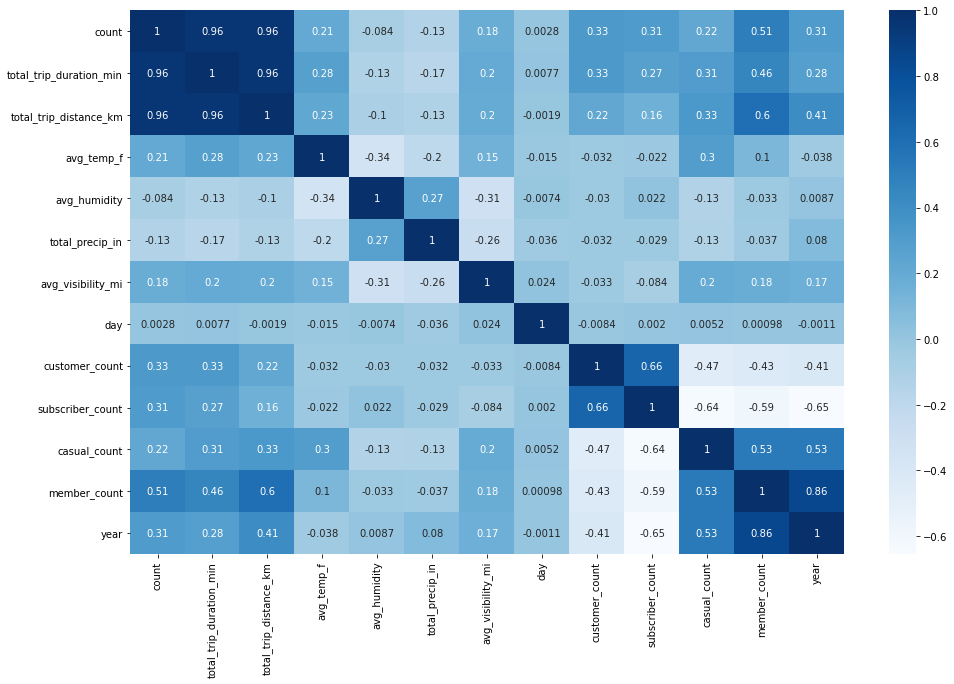

In [474]:
plt.figure(figsize = (16, 10))
sns.heatmap(bike.corr(), annot = True, cmap="Blues")
plt.show()

In [1169]:
#dropping columns we would not be using anymore unnecessary columns
bike.drop(['start_date','customer_count', 'subscriber_count','day'], axis=1, inplace = True)
bike.head()

,count,total_trip_duration_sec,total_trip_distance_km,avg_temp_f,avg_humidity,total_precip_in,avg_visibility_mi,weather,month,year,weekday,season
0,1064,730781,1506.94,51.865602,87.675752,0.00,12.669173,Mostly Cloudy,January,2018,Sun,Winter
1,3045,1795363,4851.08,52.394417,81.845977,0.00,12.760591,Cloudy,January,2018,Mon,Winter
2,2752,1610416,4468.47,51.521802,92.980741,22.31,8.361192,Mist and Fog,January,2018,Tue,Winter
3,3159,1823468,5053.81,57.456474,89.712567,0.84,13.438113,Cloudy,January,2018,Wed,Winter
4,2053,1156630,3145.21,56.450073,95.968826,20.89,12.544569,Cloudy,January,2018,Thur,Winter


In [1171]:
bike1 = bike.copy()

In [1172]:
months=pd.get_dummies(bike1.month,drop_first=True)
weekdays=pd.get_dummies(bike1.weekday,drop_first=True)
weather=pd.get_dummies(bike1.weather,drop_first=True)
seasons=pd.get_dummies(bike1.season,drop_first=True)

In [1174]:
# Add the results to the original bike dataframe
bike1=pd.concat([months,weekdays,weather,seasons,bike1],axis=1)
bike1.head()

,Mon,Sat,Sun,Thur,Tue,Wed,Haze,Mist and Fog,Mostly Clear,Mostly Cloudy,Partly Cloudy,Rain,count,total_trip_duration_sec,total_trip_distance_km,avg_temp_f,avg_humidity,total_precip_in,avg_visibility_mi,weather,month,year,weekday,season
0,0,0,1,0,0,0,0,0,0,1,0,0,1064,730781,1506.94,51.865602,87.675752,0.00,12.669173,Mostly Cloudy,January,2018,Sun,Winter
1,1,0,0,0,0,0,0,0,0,0,0,0,3045,1795363,4851.08,52.394417,81.845977,0.00,12.760591,Cloudy,January,2018,Mon,Winter
2,0,0,0,0,1,0,0,1,0,0,0,0,2752,1610416,4468.47,51.521802,92.980741,22.31,8.361192,Mist and Fog,January,2018,Tue,Winter
3,0,0,0,0,0,1,0,0,0,0,0,0,3159,1823468,5053.81,57.456474,89.712567,0.84,13.438113,Cloudy,January,2018,Wed,Winter
4,0,0,0,1,0,0,0,0,0,0,0,0,2053,1156630,3145.21,56.450073,95.968826,20.89,12.544569,Cloudy,January,2018,Thur,Winter


In [1176]:
# Drop 'season','month','weekday','weathersit' as we have created the dummies for it
bike1.drop(['season','month','weekday','weather'], axis = 1, inplace = True)
bike1.head()

,Mon,Sat,Sun,Thur,Tue,Wed,Haze,Mist and Fog,Mostly Clear,Mostly Cloudy,Partly Cloudy,Rain,count,total_trip_duration_sec,total_trip_distance_km,avg_temp_f,avg_humidity,total_precip_in,avg_visibility_mi,year
0,0,0,1,0,0,0,0,0,0,1,0,0,1064,730781,1506.94,51.865602,87.675752,0.00,12.669173,2018
1,1,0,0,0,0,0,0,0,0,0,0,0,3045,1795363,4851.08,52.394417,81.845977,0.00,12.760591,2018
2,0,0,0,0,1,0,0,1,0,0,0,0,2752,1610416,4468.47,51.521802,92.980741,22.31,8.361192,2018
3,0,0,0,0,0,1,0,0,0,0,0,0,3159,1823468,5053.81,57.456474,89.712567,0.84,13.438113,2018
4,0,0,0,1,0,0,0,0,0,0,0,0,2053,1156630,3145.21,56.450073,95.968826,20.89,12.544569,2018


## Model Building

In [ ]:
# THis space will get filled in due time

In [545]:

# --- Group by start/end station info to compute route frequencies ---
routes = merged_df.groupby([
    'start_station_id', 'start_station_name', 
    'start_station_latitude', 'start_station_longitude',
    'end_station_id', 'end_station_name', 
    'end_station_latitude', 'end_station_longitude'
]).size().reset_index(name='count')

# Optionally, filter to top 50 most frequent routes for clarity
top_routes = routes.sort_values(by='count', ascending=False).head(50)

# Get the maximum count for scaling line thickness
max_count = top_routes['count'].max()

# Create a folium map using a dark tile style (CartoDB dark_matter)
map_sf = folium.Map(location=[37.77, -122.42], zoom_start=12, tiles='CartoDB dark_matter')

# Add each route with a glow effect
for idx, row in top_routes.iterrows():
    start = [row['start_station_latitude'], row['start_station_longitude']]
    end = [row['end_station_latitude'], row['end_station_longitude']]
    # Scale the weight based on the route count
    weight = 2 + 10 * (row['count'] / max_count)
    
    # Add a thicker, semi-transparent red line underneath to simulate a glow effect
    folium.PolyLine(
        locations=[start, end],
        weight=weight + 1,   # a bit thicker than the main line
        color='red',
        opacity=0.3,         # lower opacity for glow effect
    ).add_to(map_sf)
    
    # Add the main solid red line on top
    folium.PolyLine(
        locations=[start, end],
        weight=0.5,
        color='red',
        opacity=0.7,
        popup=f"{row['start_station_name']} to {row['end_station_name']}<br>Count: {row['count']}"
    ).add_to(map_sf)

# Display the map
map_sf


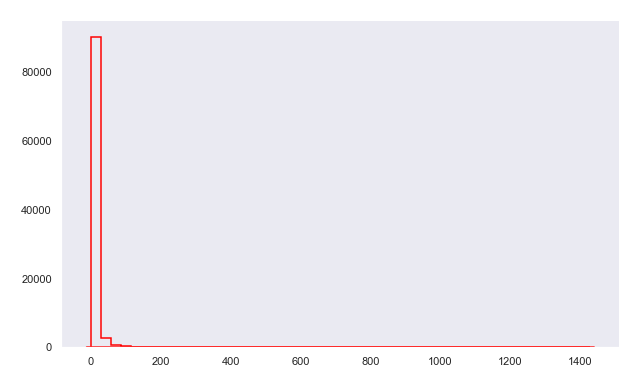

In [583]:


# Set the style and colors for a dark, black background
sns.set_style("dark")
plt.figure(figsize=(10, 6))

# Plot the histogram using plt.hist with step lines
n, bins, patches = plt.hist(
    cleaned_df['trip_duration_minutes'].dropna(),
    bins=50,
    histtype='step',
    linewidth=1.5,
    color='red'
)

# Overlay the KDE using seaborn.kdeplot with a red line
sns.kdeplot(
    cleaned_df['trip_duration_minutes'].dropna(),
    color='red',
    linewidth=2
)

# Set axis labels and title in white for contrast
plt.xlabel("Trip Duration (minutes)", color='white')
plt.ylabel("Density", color='white')
plt.title("Distribution of Trip Duration (minutes)", color='white')

# Remove top and right spines (despine)
sns.despine()

# Set the background of the axes and figure to black
#plt.gca().set_facecolor('grey')
#plt.gcf().set_facecolor('grey')

plt.show()


In [628]:
# Load Bikeshare data
#bikeshare_data = pd.read_excel("201801-bikeshare.xlsb", engine="pyxlsb")
#bikeshare_data.dropna(subset=['start_station_latitude', 'start_station_longitude', 
#                              'end_station_latitude', 'end_station_longitude'], inplace=True)

# Initialize map centered at average coordinates
m = folium.Map(
    location=[
        merged_df['start_station_latitude'].mean(), 
        merged_df['start_station_longitude'].mean()
    ],
    zoom_start=13
)

# Draw lines for the first 200 trips (for clarity)
for _, row in merged_df.head(500).iterrows():
    folium.PolyLine(
        locations=[
            (row['start_station_latitude'], row['start_station_longitude']),
            (row['end_station_latitude'], row['end_station_longitude'])
        ],
        color='blue',
        weight=1,
        opacity=0.5
    ).add_to(m)

# Save to an HTML file and display it directly
m.save('bike_sharing_map.html')

# Display map in Jupyter Notebook

display(IFrame('bike_sharing_map.html', width=800, height=500))


,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,start_time_hour,start_time_minute,start_time_second,end_time_hour,end_time_minute,end_time_second,year,month,weekday,Pressure,trip_distance_km,trip_duration_minutes,trip_duration_hours,Has Kiosk,Dock Count
count,94802.000000,94802.000000,94802.000000,94802.000000,94802.00000,94802.000000,94802.000000,94802.000000,94802.000000,94802.000000,94802.000000,94802.000000,94802.000000,94802.000000,94802.0,94802.0,94802.000000,94802.000000,94802.000000,94802.000000,94802.000000,91670.0,91670.000000
mean,870.935930,103.766302,37.773321,-122.361677,101.00982,37.773536,-122.360776,2048.751609,13.221557,29.488344,29.466878,13.404907,29.607888,29.522679,2018.0,1.0,2.528143,30.173097,1.621422,14.514715,0.087604,1.0,25.673754
std,2550.596891,87.730464,0.085744,0.105253,86.77949,0.085552,0.104580,1091.507513,4.648920,17.408026,17.306475,4.665163,17.441489,17.274123,0.0,0.0,1.790199,0.141662,1.015398,42.511477,0.726785,0.0,6.912964
min,61.000000,3.000000,37.317298,-122.444293,3.00000,37.317298,-122.444293,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.0,1.0,0.000000,29.550000,0.000000,1.000000,0.000000,1.0,0.000000
25%,359.000000,30.000000,37.771662,-122.412408,27.00000,37.773063,-122.411306,1133.000000,9.000000,14.000000,15.000000,9.000000,15.000000,15.000000,2018.0,1.0,1.000000,30.100000,0.910000,6.000000,0.000000,1.0,19.000000
50%,555.000000,79.000000,37.781270,-122.398773,76.00000,37.781752,-122.398436,2151.500000,13.000000,29.000000,29.000000,14.000000,29.000000,30.000000,2018.0,1.0,2.000000,30.180000,1.400000,9.000000,0.000000,1.0,27.000000
75%,854.000000,160.000000,37.795392,-122.390428,157.00000,37.795392,-122.390428,3015.000000,17.000000,45.000000,44.000000,17.000000,45.000000,45.000000,2018.0,1.0,4.000000,30.270000,2.100000,14.000000,0.000000,1.0,31.000000
max,85546.000000,342.000000,37.880222,-121.874119,342.00000,37.880222,-121.874119,3744.000000,23.000000,59.000000,59.000000,23.000000,59.000000,59.000000,2018.0,1.0,6.000000,30.480000,14.070000,1426.000000,24.000000,1.0,39.000000


In [630]:
merged_df.sort_values('trip_duration_minutes', ascending = False)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,start_date,end_date,start_time_new,end_time_new,start_time_hour,start_time_minute,start_time_second,end_time_hour,end_time_minute,end_time_second,year,month,weekday,weekday_name,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,trip_distance_km,trip_duration_minutes,trip_duration_hours,Has Kiosk,Dock Count,analysis_neighborhood,Route Id
88024,85546,2018-01-30 14:45:44.480,2018-01-31 14:31:31.053,6,The Embarcadero at Sansome St,37.804770,-122.403234,24,Spear St at Folsom St,37.789677,-122.390428,364,Customer,No,2018-01-30,2018-01-31,14:45:44.480000,14:31:31.053000,14,45,44,14,31,31,2018,1,1,Tuesday,Mostly Clear,64°F,50°F,60%,30.09,NW 10 MPH,0 in.,10mi.,2.02,1426.0,24.0,1.0,23.0,Financial District/South Beach,6-24
92908,85422,2018-01-31 16:13:34.351,2018-02-01 15:57:17.310,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,No,2018-01-31,2018-02-01,16:13:34.351000,15:57:17.310000,16,13,34,15,57,17,2018,1,2,Wednesday,Mostly Cloudy,63°F,47°F,56%,30.04,NW 10 MPH,0 in.,10mi.,0.00,1424.0,24.0,1.0,38.0,Financial District/South Beach,15-15
32897,85079,2018-01-13 13:44:59.589,2018-01-14 13:22:59.272,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,31,Raymond Kimbell Playground,37.783813,-122.434559,2841,Customer,No,2018-01-13,2018-01-14,13:44:59.589000,13:22:59.272000,13,44,59,13,22,59,2018,1,5,Saturday,Partly Cloudy,61°F,51°F,70%,30.16,SE 5 MPH,0 in.,10mi.,1.73,1418.0,24.0,1.0,31.0,Tenderloin,43-31
71627,84609,2018-01-25 17:35:02.514,2018-01-26 17:05:12.371,49,S Park St at 3rd St,37.780760,-122.394989,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,3642,Subscriber,No,2018-01-25,2018-01-26,17:35:02.514000,17:05:12.371000,17,35,2,17,5,12,2018,1,3,Thursday,Mostly Cloudy,52°F,44°F,75%,30.16,SW 6 MPH,0 in.,10mi.,1.07,1410.0,24.0,1.0,30.0,Financial District/South Beach,49-3
21904,84193,2018-01-10 10:01:32.352,2018-01-11 09:24:46.268,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,72,Page St at Scott St,37.772406,-122.435650,3653,Subscriber,No,2018-01-10,2018-01-11,10:01:32.352000,09:24:46.268000,10,1,32,9,24,46,2018,1,2,Wednesday,Cloudy,54°F,49°F,83%,30.18,SW 10 MPH,0 in.,10mi.,4.45,1403.0,23.0,1.0,38.0,Financial District/South Beach,15-72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37071,83,2018-01-15 16:00:25.119,2018-01-15 16:01:48.467,11,Davis St at Jackson St,37.797280,-122.398436,11,Davis St at Jackson St,37.797280,-122.398436,1722,Customer,No,2018-01-15,2018-01-15,16:00:25.119000,16:01:48.467000,16,0,25,16,1,48,2018,1,0,Monday,Haze,59°F,48°F,67%,30.09,N 3 MPH,0 in.,6mi.,0.00,1.0,0.0,1.0,35.0,Financial District/South Beach,11-11
44577,68,2018-01-17 14:59:41.785,2018-01-17 15:00:50.395,269,Telegraph Ave at Carleton St,37.862320,-122.258801,269,Telegraph Ave at Carleton St,37.862320,-122.258801,872,Subscriber,No,2018-01-17,2018-01-17,14:59:41.785000,15:00:50.395000,14,59,41,15,0,50,2018,1,2,Wednesday,Mist and Fog,58°F,54°F,87%,30.19,W 6 MPH,0 in.,6mi.,0.00,1.0,0.0,1.0,19.0,NaN,269-269
22649,78,2018-01-10 16:34:40.508,2018-01-10 16:35:58.740,42,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,42,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,2748,Subscriber,Yes,2018-01-10,2018-01-10,16:34:40.508000,16:35:58.740000,16,34,40,16,35,58,2018,1,2,Wednesday,Mostly Cloudy,55°F,53°F,93%,30.18,E 3 MPH,0 in.,10mi.,0.00,1.0,0.0,1.0,19.0,Tenderloin,42-42
19142,87,2018-01-09 17:01:49.986,2018-01-09 17:03:17.724,41,Golden Gate Ave at Polk St,37.781270,-122.418740,43,

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,start_date,end_date,start_time_new,end_time_new,start_time_hour,start_time_minute,start_time_second,end_time_hour,end_time_minute,end_time_second,year,month,weekday,weekday_name,Weather,Temp,Dewpt,Hum,Pressure,Winds,Precip,Visibility,trip_distance_km,trip_duration_minutes,trip_duration_hours,Has Kiosk,Dock Count,analysis_neighborhood,Route Id
